Implement and Test CVAE

In [1]:
# import libraries
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn. functional as F
import torch.optim as optim
import os
import sys

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Change directories to point to your data!
data_path = '/content/drive/MyDrive/Copy of FashionMNIST'
specfic_path = '/content/drive/MyDrive/Copy of FashionMNIST.zip'
#!ls "$root_dir"
root_dir = "/content/data"


!unzip '/content/drive/MyDrive/Copy of FashionMNIST.zip' -d "$root_dir"

Archive:  /content/drive/MyDrive/Copy of FashionMNIST.zip
   creating: /content/data/FashionMNIST/
  inflating: /content/data/FashionMNIST/.DS_Store  
  inflating: /content/data/__MACOSX/FashionMNIST/._.DS_Store  
   creating: /content/data/FashionMNIST/processed/
   creating: /content/data/FashionMNIST/raw/
  inflating: /content/data/FashionMNIST/processed/training.pt  
  inflating: /content/data/FashionMNIST/processed/test.pt  
  inflating: /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte  
  inflating: /content/data/FashionMNIST/raw/train-images-idx3-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-images-idx3-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-labels-idx1-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz 

In [7]:
def load_data():
    transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/', train=True, download=True,
                             transform=transform),batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./data/', train=False, download=True,
                             transform=transform),batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    return train_loader, test_loader

In [10]:
batch_size = 100
learning_rate = 1e-3
max_epoch = 10
num_workers = 5
load_epoch = -1
generate = True

CVAE Model

In [13]:
# create CVAE model
class CVAE(nn.Module):
    def __init__(self,latent_size=64,num_classes=10):
        super(CVAE,self).__init__()
        self.latent_size = latent_size
        self.num_classes = num_classes

        # For encode
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(4*4*64,300)
        self.mu = nn.Linear(300, self.latent_size)
        self.logvar = nn.Linear(300, self.latent_size)

        # For decoder
        self.linear2 = nn.Linear(self.latent_size + self.num_classes, 300)
        self.linear3 = nn.Linear(300,4*4*64)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=5,stride=2)
        self.conv4 = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2)
        self.conv5 = nn.ConvTranspose2d(1, 1, kernel_size=4)

    def encoder(self,x,y):
        y = torch.argmax(y, dim=1).reshape((y.shape[0],1,1,1))
        y = torch.ones(x.shape).to(device)*y
        t = torch.cat((x,y),dim=1)
        
        t = F.relu(self.conv1(t))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))
        
        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(device)
        return eps*std + mu
    
    def unFlatten(self, x):
        return x.reshape((x.shape[0], 64, 4, 4))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = F.relu(self.conv5(t))
        return t


    def forward(self, x, y):
        mu, logvar = self.encoder(x,y)
        z = self.reparameterize(mu,logvar)

        # Class conditioning
        z = torch.cat((z, y.float()), dim=1)
        pred = self.decoder(z)
        return pred, mu, logvar

In [14]:
def loss_function(x, pred, mu, logvar):
    recon_loss = F.mse_loss(pred, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, kld

In [15]:
# Train CVAE model
def train(epoch, model, train_loader, optim):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    for i,(x,y) in enumerate(train_loader):
        try:
            label = np.zeros((x.shape[0], 10))
            label[np.arange(x.shape[0]), y] = 1
            label = torch.tensor(label)

            optim.zero_grad()   
            pred, mu, logvar = model(x.to(device),label.to(device))
            
            recon_loss, kld = loss_function(x.to(device),pred, mu, logvar)
            loss = recon_loss + kld
            loss.backward()
            optim.step()

            total_loss += loss.cpu().data.numpy()*x.shape[0]
            reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
            kld_loss += kld.cpu().data.numpy()*x.shape[0]
            if i == 0:
                print("Gradients")
                for name,param in model.named_parameters():
                    if "bias" in name:
                        print(name,param.grad[0],end=" ")
                    else:
                        print(name,param.grad[0,0],end=" ")
                    print()
        except Exception as e:
            # traceback.print_exe()
            torch.cuda.empty_cache()
            continue
    
    reconstruction_loss /= len(train_loader.dataset)
    kld_loss /= len(train_loader.dataset)
    total_loss /= len(train_loader.dataset)
    return total_loss, kld_loss,reconstruction_loss

In [16]:
# test CVAE model
def test(epoch, model, test_loader):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    with torch.no_grad():
        for i,(x,y) in enumerate(test_loader):
            try:
                label = np.zeros((x.shape[0], 10))
                label[np.arange(x.shape[0]), y] = 1
                label = torch.tensor(label)

                pred, mu, logvar = model(x.to(device),label.to(device))
                recon_loss, kld = loss_function(x.to(device),pred, mu, logvar)
                loss = recon_loss + kld

                total_loss += loss.cpu().data.numpy()*x.shape[0]
                reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
                kld_loss += kld.cpu().data.numpy()*x.shape[0]
                if i == 0:
                    # print("gr:", x[0,0,:5,:5])
                    # print("pred:", pred[0,0,:5,:5])
                    plot(epoch, pred.cpu().data.numpy(), y.cpu().data.numpy())
            except Exception as e:
                # traceback.print_exe()
                torch.cuda.empty_cache()
                continue
    reconstruction_loss /= len(test_loader.dataset)
    kld_loss /= len(test_loader.dataset)
    total_loss /= len(test_loader.dataset)
    return total_loss, kld_loss,reconstruction_loss 

In [18]:
# generate images
def generate_image(epoch,z, y, model):
    with torch.no_grad():
        label = np.zeros((y.shape[0], 10))
        label[np.arange(z.shape[0]), y] = 1
        label = torch.tensor(label)

        pred = model.decoder(torch.cat((z.to(device),label.float().to(device)), dim=1))
        plot(epoch, pred.cpu().data.numpy(), y.cpu().data.numpy(),name='Eval_')
        print("plot data")

In [19]:
def plot(epoch, pred, y,name='test_'):
    if not os.path.isdir('./images'):
        os.mkdir('./images')
    fig = plt.figure(figsize=(32,32))
    for i in range(6):
        ax = fig.add_subplot(3,2,i+1)
        ax.imshow(pred[i,0],cmap='gray')
        ax.axis('off')
        ax.title.set_text(str(y[i]))
    # plt.savefig("./images1/{}epoch_{}.jpg".format(name, epoch))
    plt.figure(figsize=(10,10))
    # plt.imsave("./images/pred_{}.jpg".format(epoch), pred[0,0], cmap='gray')
    plt.close()

In [20]:
def save_model(model, epoch):
    if not os.path.isdir("./checkpoints"):
        os.mkdir("./checkpoints")
    file_name = './checkpoints/model_{}.pt'.format(epoch)
    torch.save(model.state_dict(), file_name)

dataloader created
model created


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Gradients
conv1.weight tensor([[ 2.3132e-03,  2.0573e-03,  7.8077e-04,  4.9245e-05, -1.5601e-04],
        [ 2.4208e-03,  2.7527e-03,  1.0261e-03, -1.0413e-04, -4.9849e-04],
        [ 2.7604e-03,  2.4032e-03,  1.0587e-03,  3.6523e-04,  1.5467e-04],
        [ 2.4010e-03,  2.3914e-03,  5.7515e-04,  2.6839e-05,  5.0397e-04],
        [ 2.5016e-03,  2.5425e-03,  1.0348e-03,  9.0411e-06,  6.4298e-04]]) 
conv1.bias tensor(0.0037) 
conv2.weight tensor([[ 2.9668e-04, -5.0558e-04,  3.0407e-04,  3.4998e-04, -1.0566e-04],
        [ 2.7638e-04, -1.3554e-04, -1.1084e-04, -1.3877e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5964e-04, -1.0667e-05],
        [-7.4259e-05,  0.0000e+00, -1.7627e-05, -1.1650e-04,  2.7245e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -5.7454e-05,  0.0000e+00]]) 
conv2.bias tensor(5.0533) 
linear1.weight tensor(1.7853) 
linear1.bias tensor(3.0049) 
mu.weight tensor(-1.1029) 
mu.bias tensor(-7.6787) 
logvar.weight tensor(0.0963) 
logvar.bias te

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


plot data
Epoch: 9/10 Train loss: 2534.281012776693, Train KLD: 451.75028737386066, Train Reconstruction Loss:2082.530722249349
Epoch: 9/10 Test loss: 2061.265899658203, Test KLD: 452.8224005126953, Test Reconstruction Loss:2061.265899658203


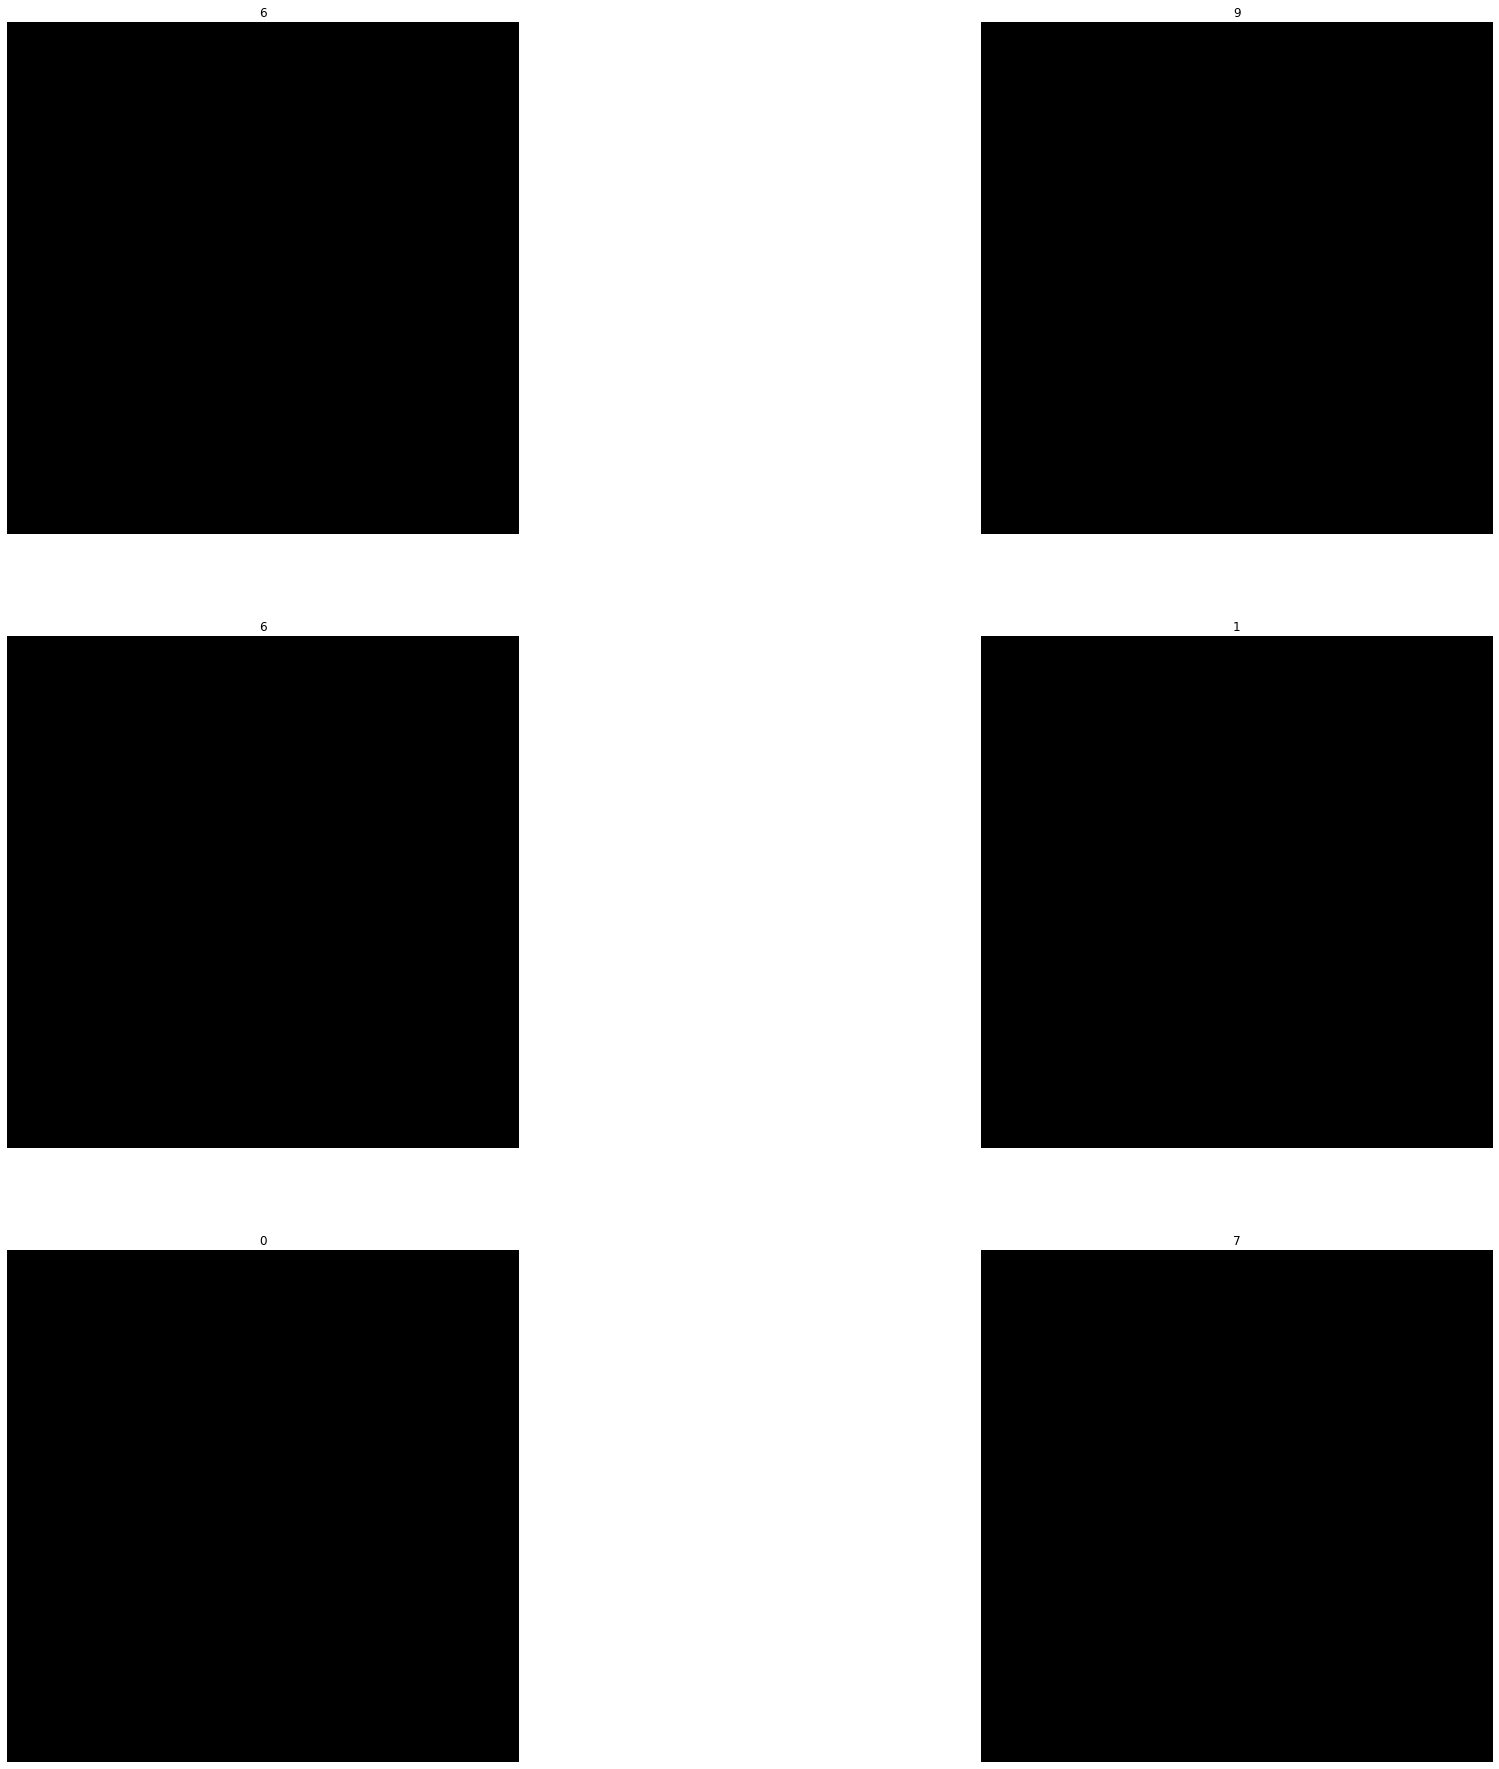

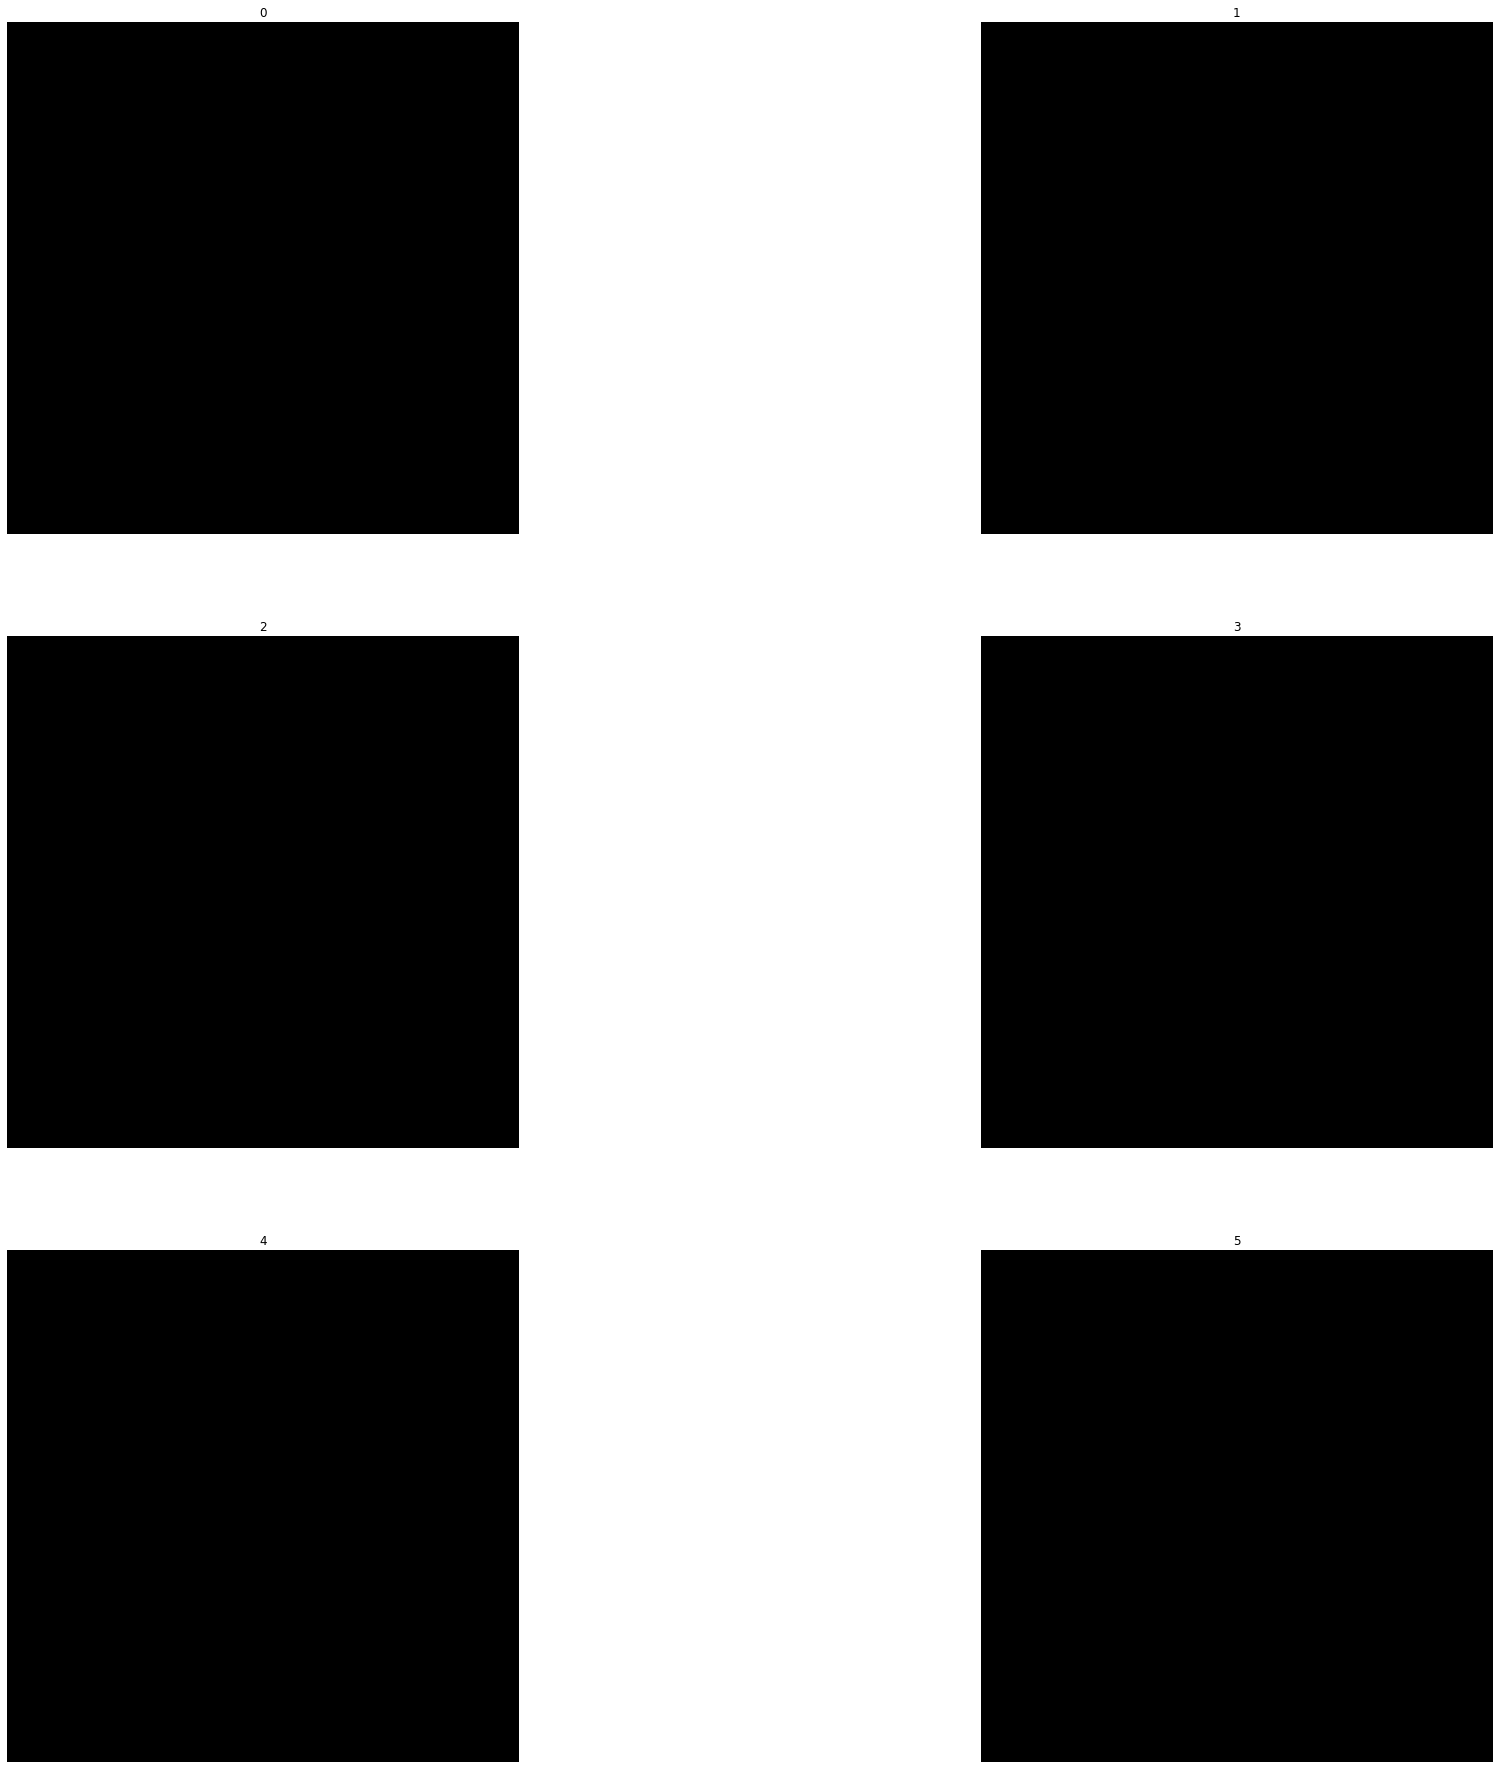

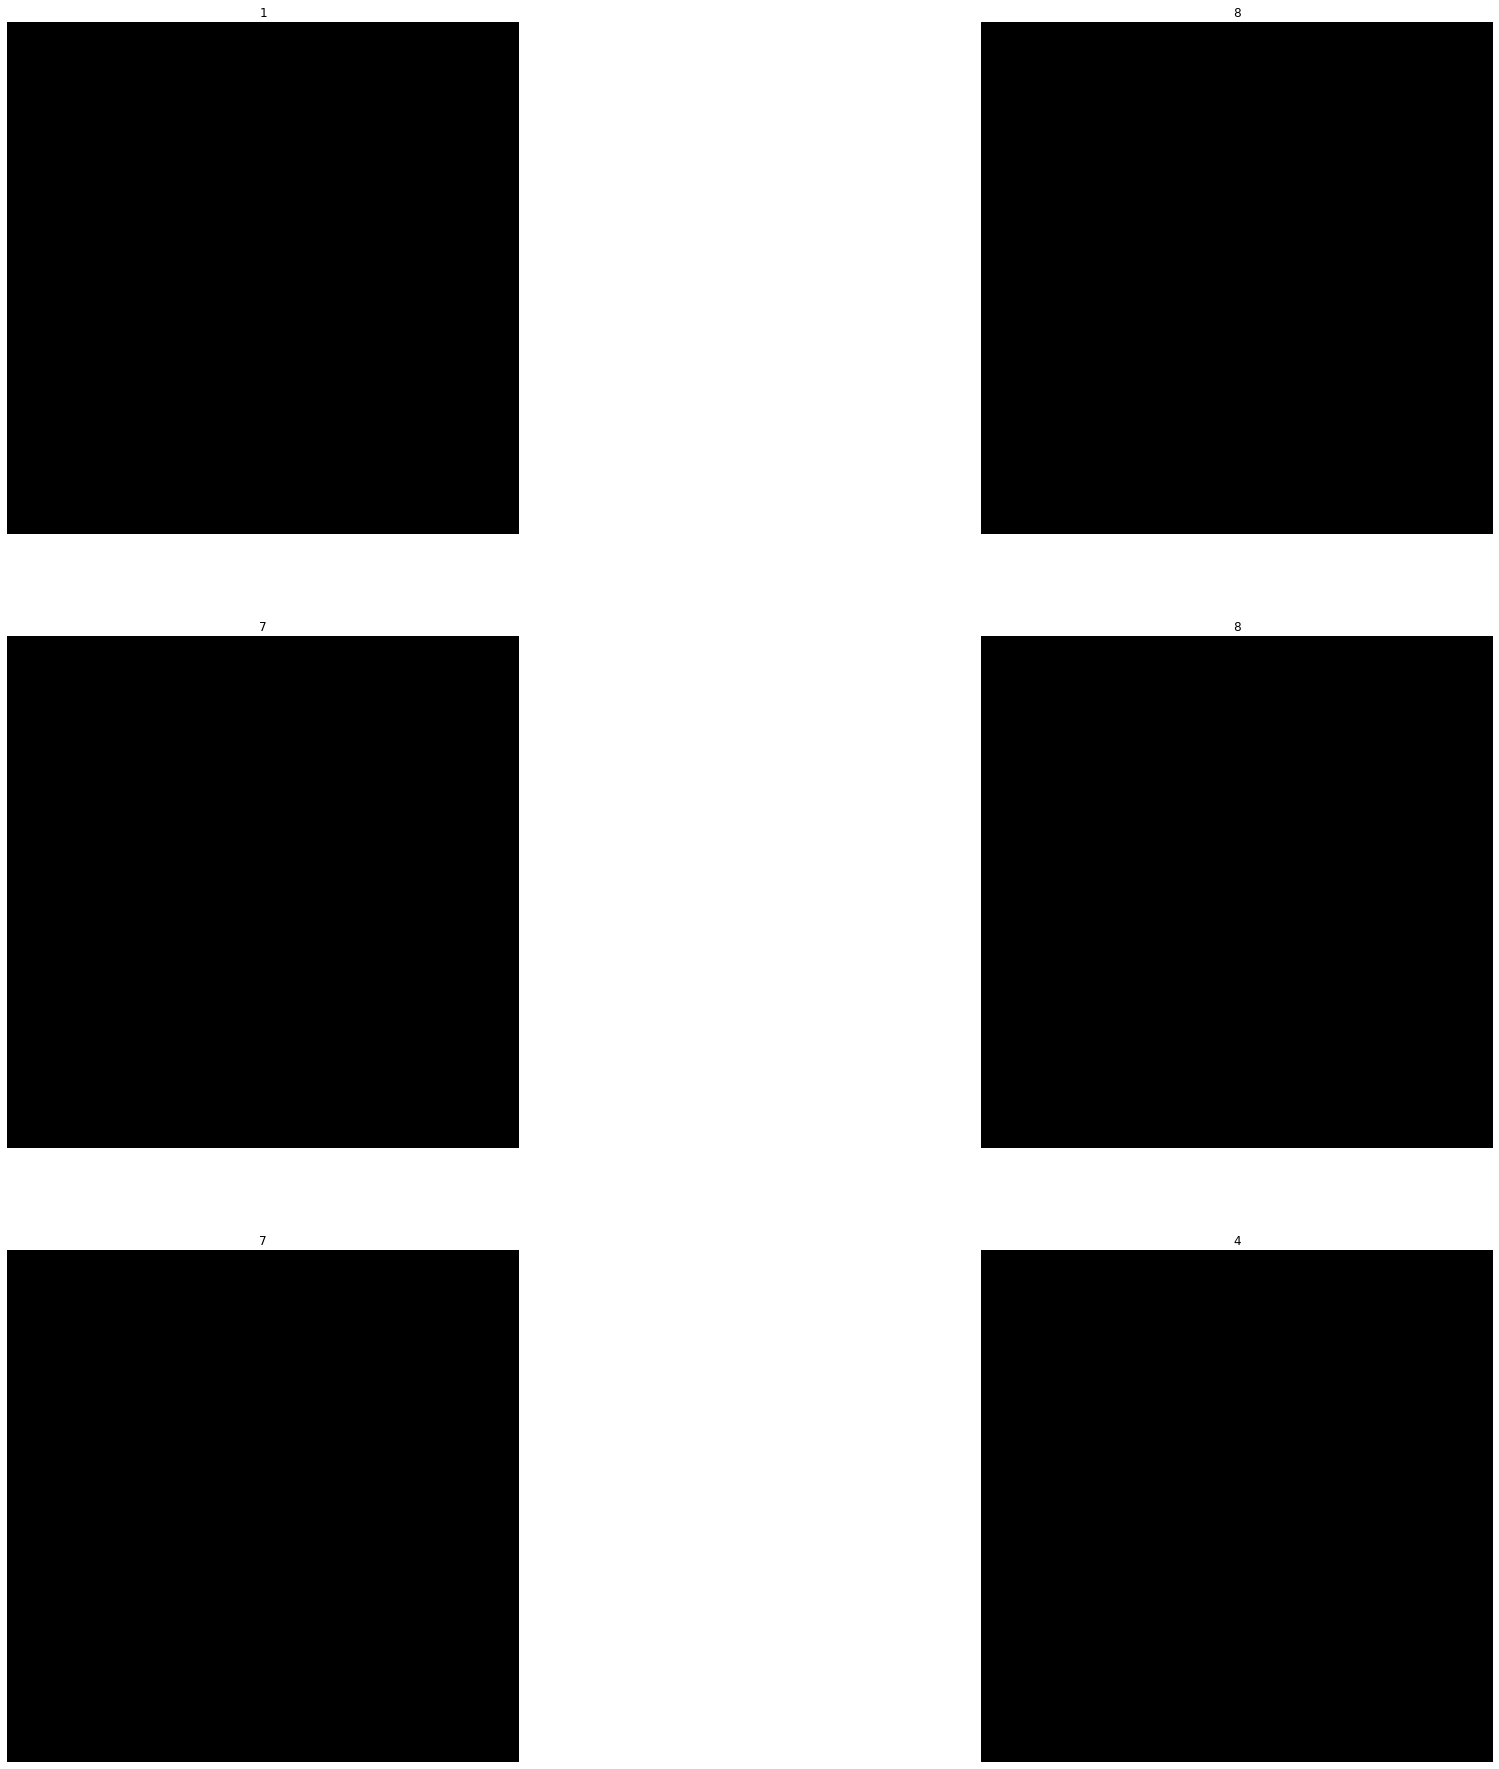

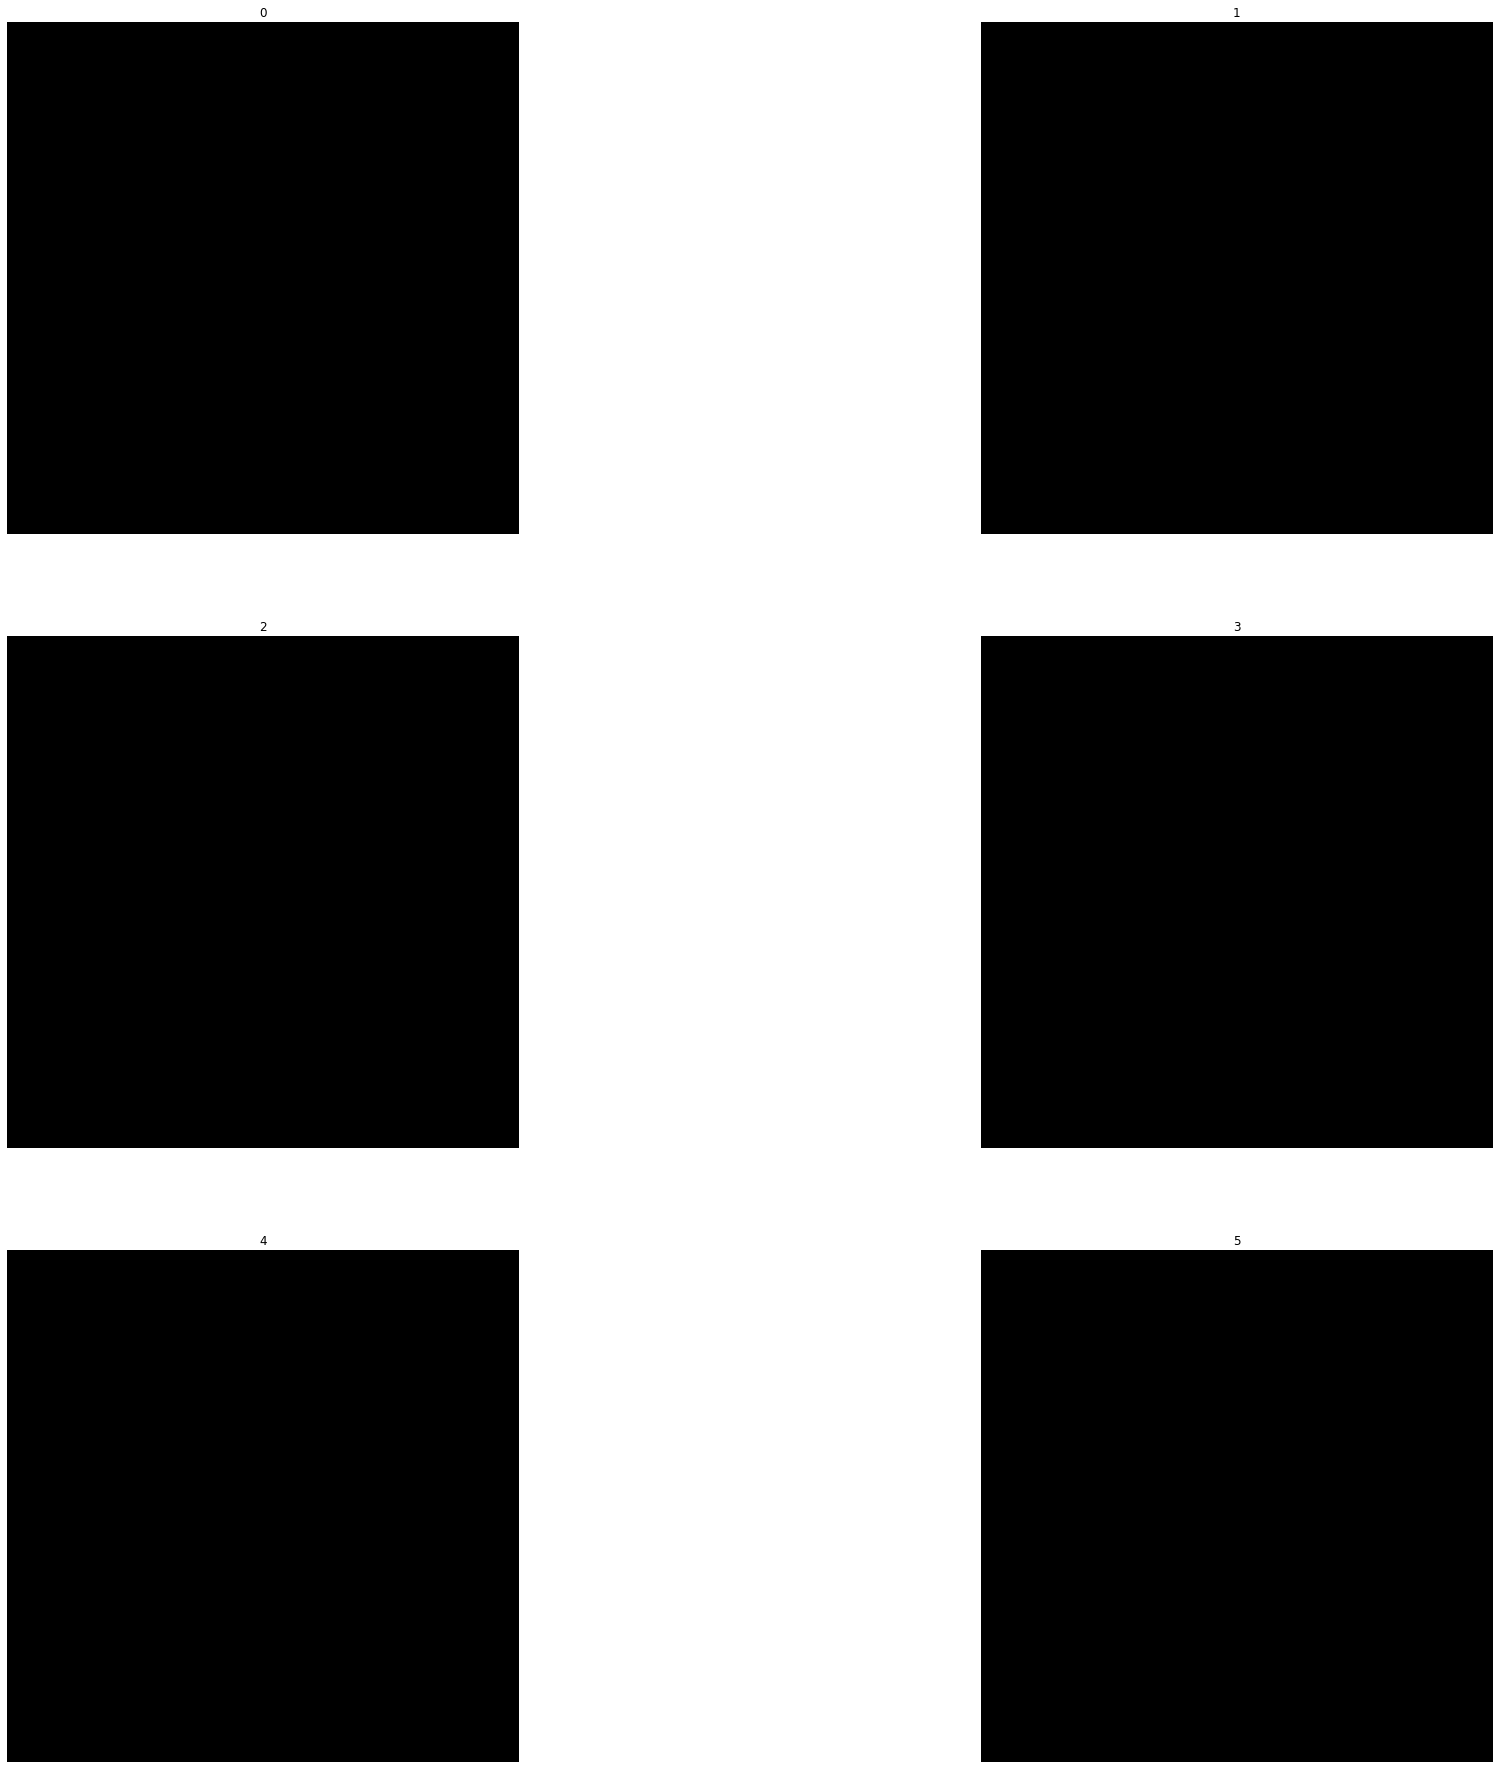

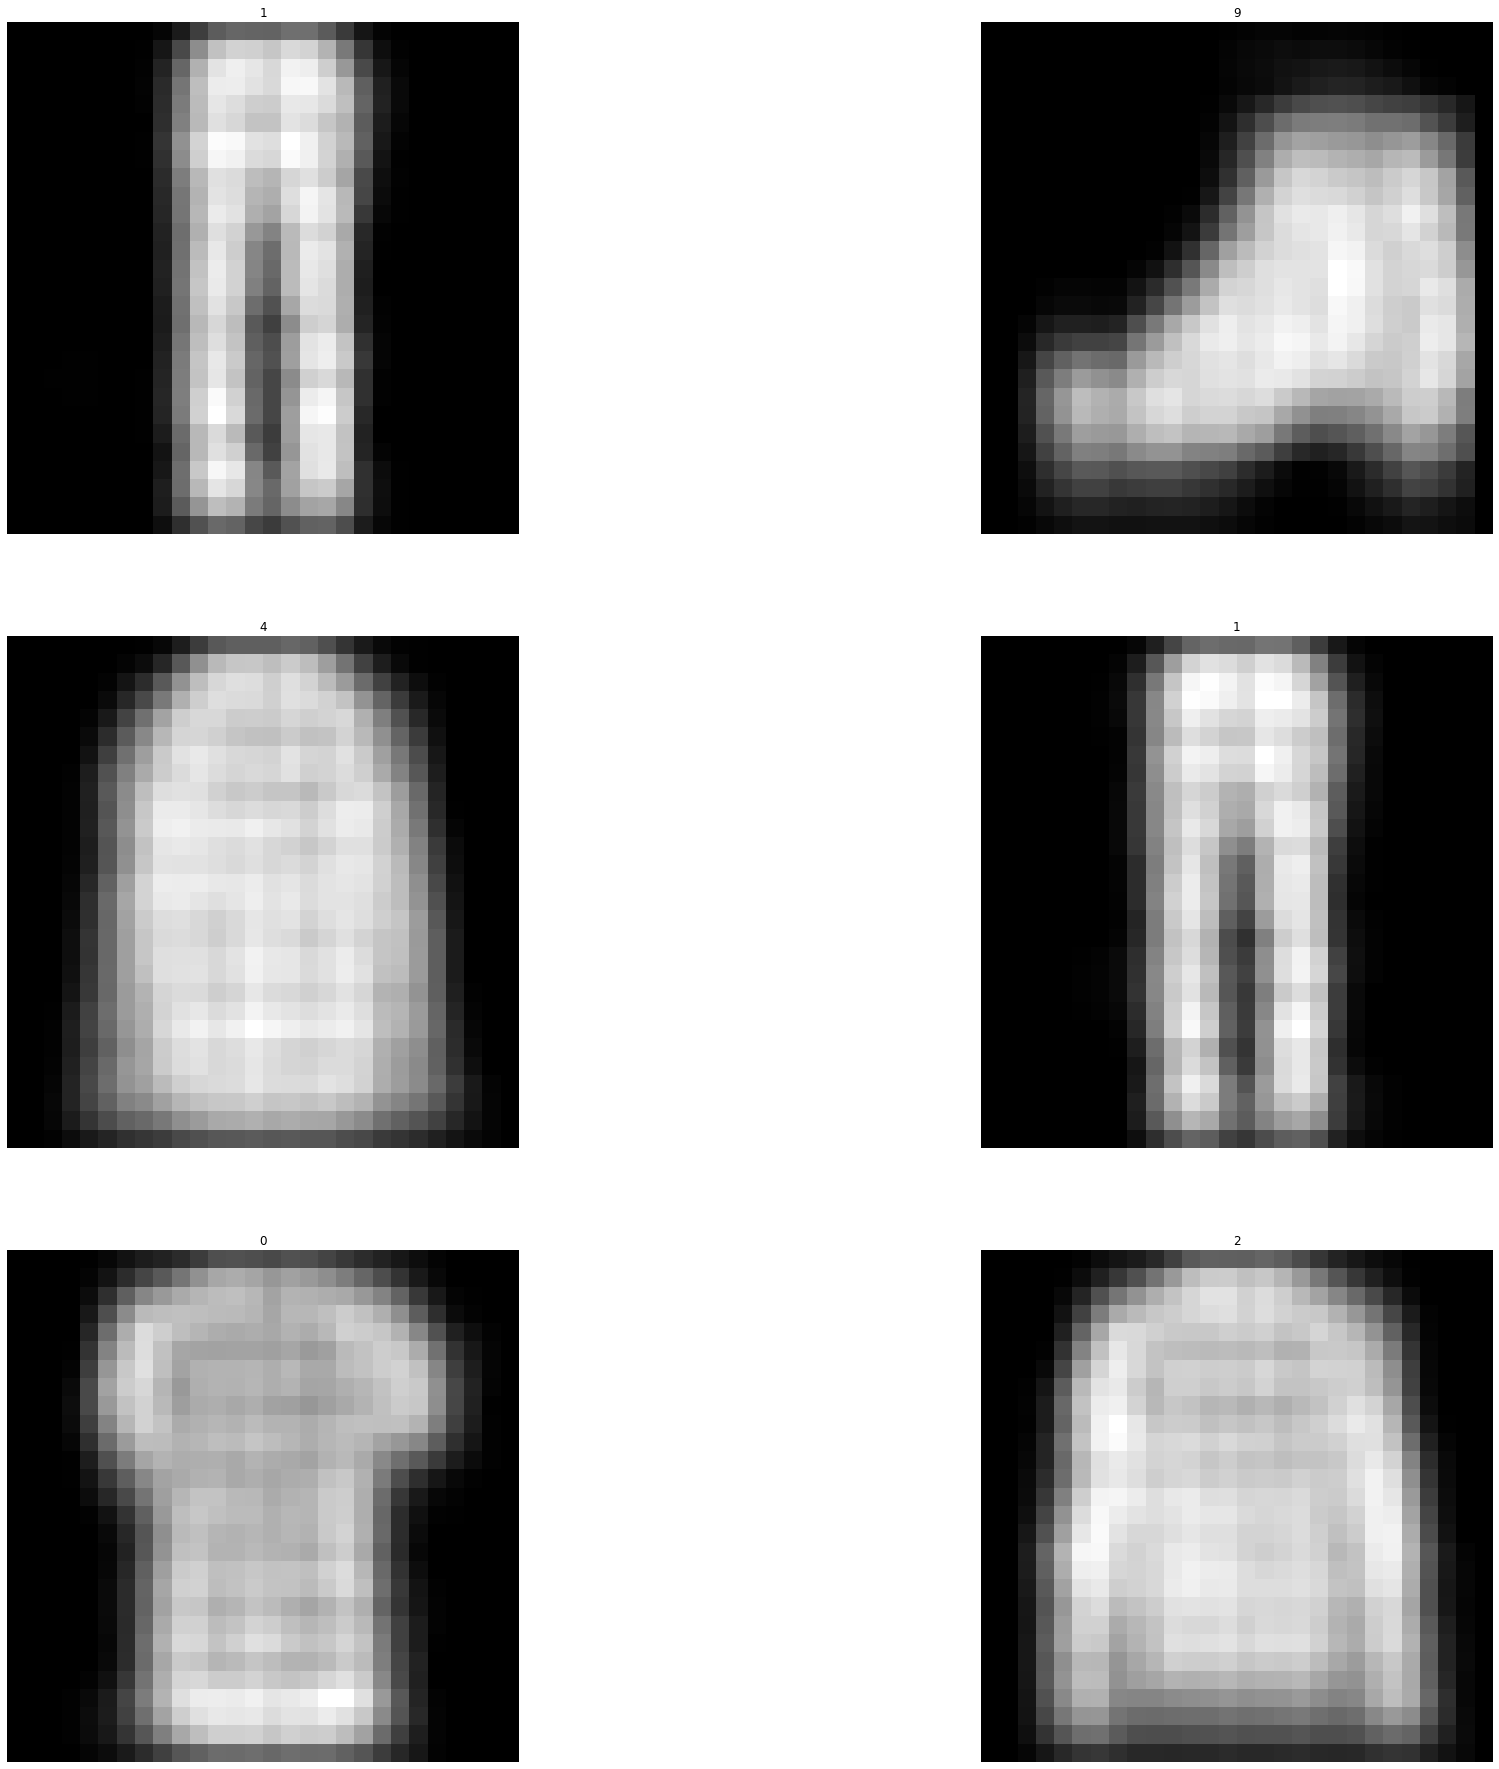

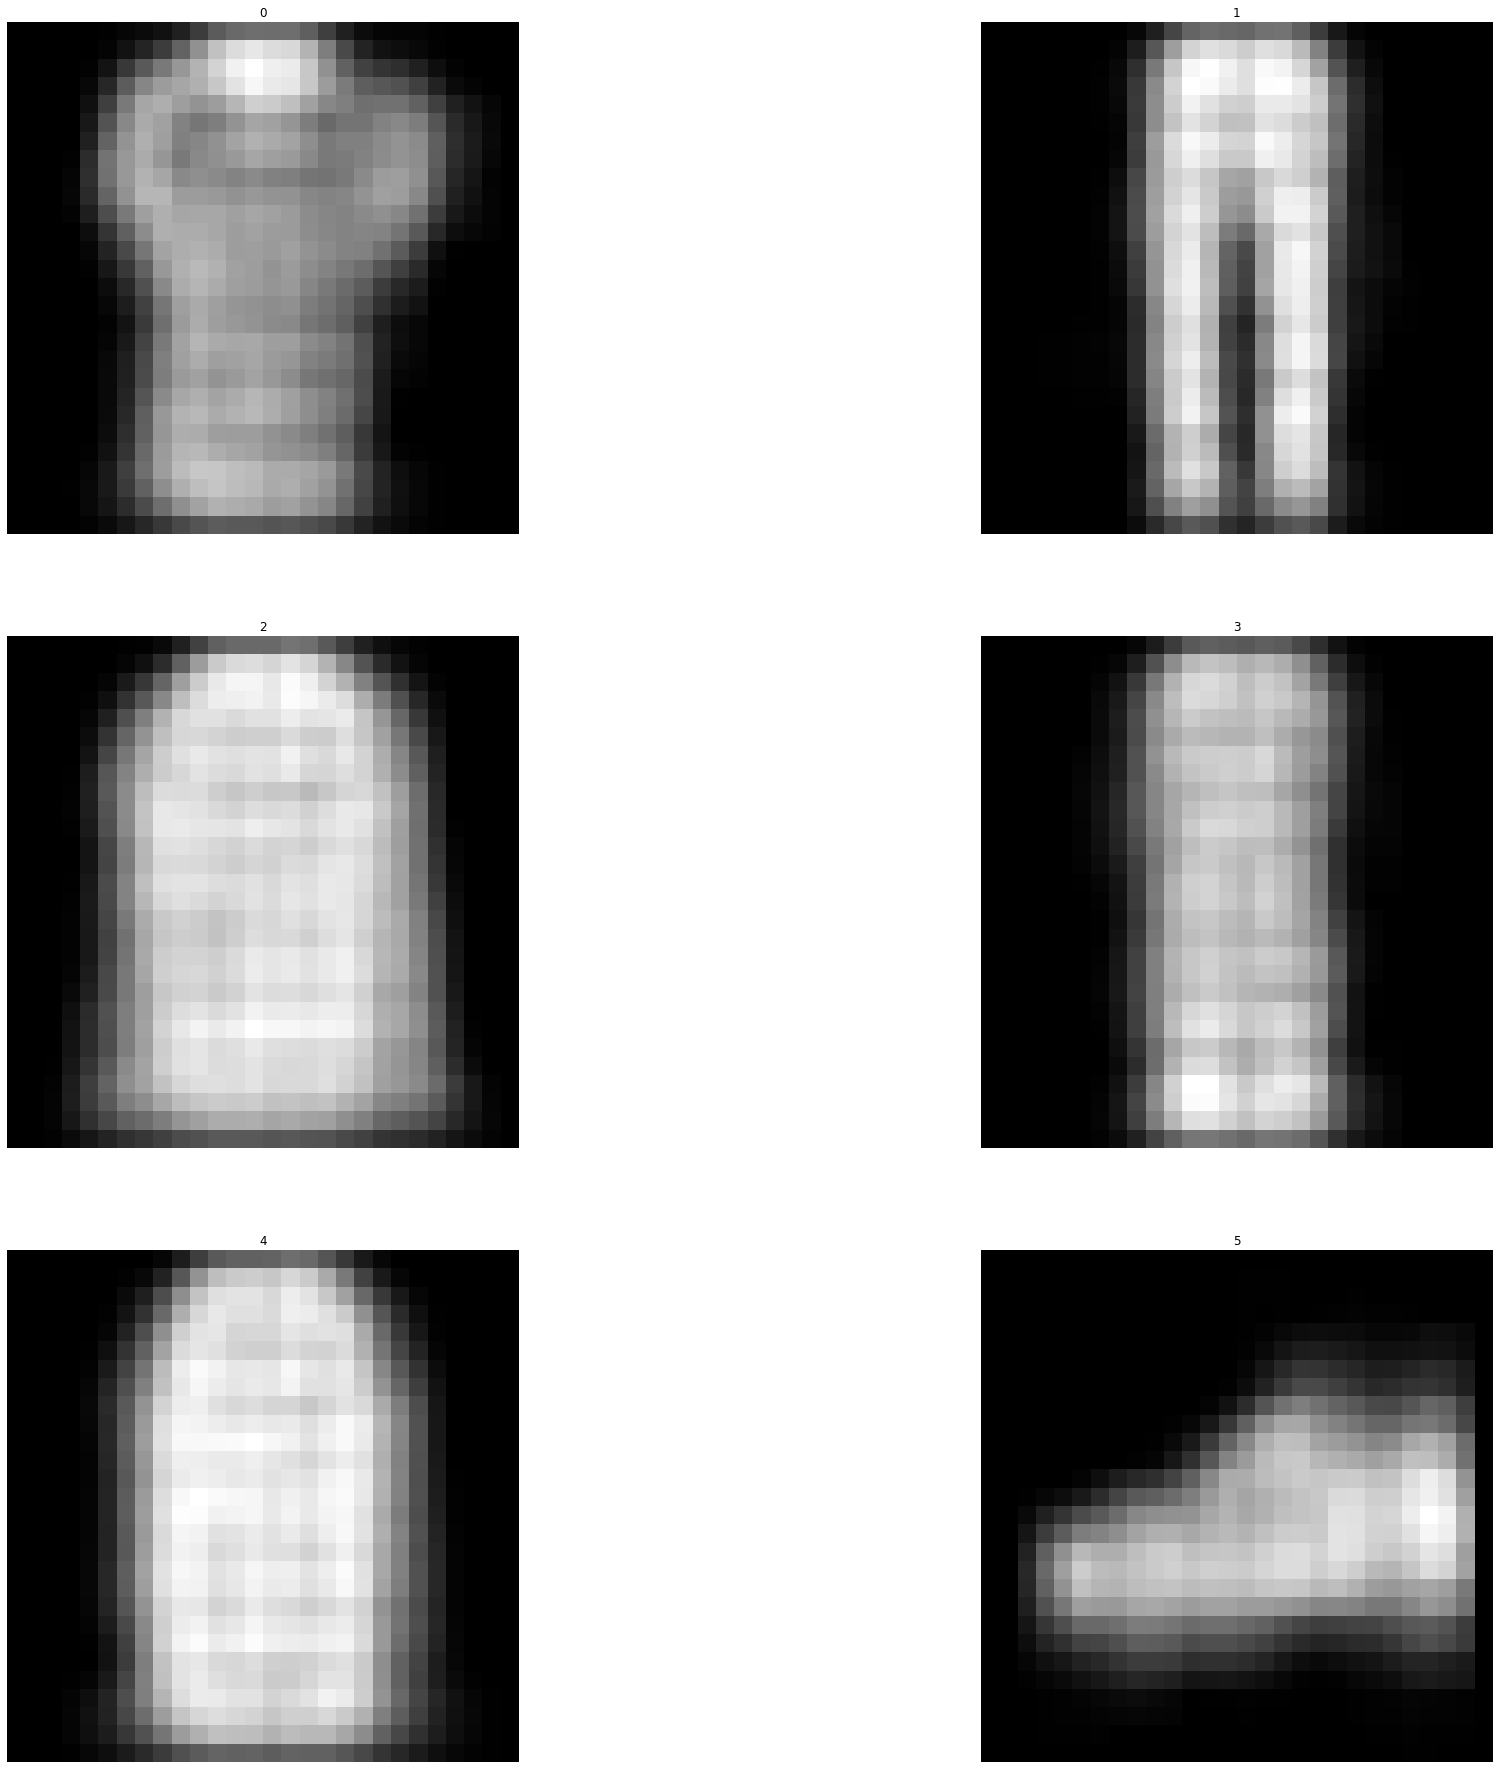

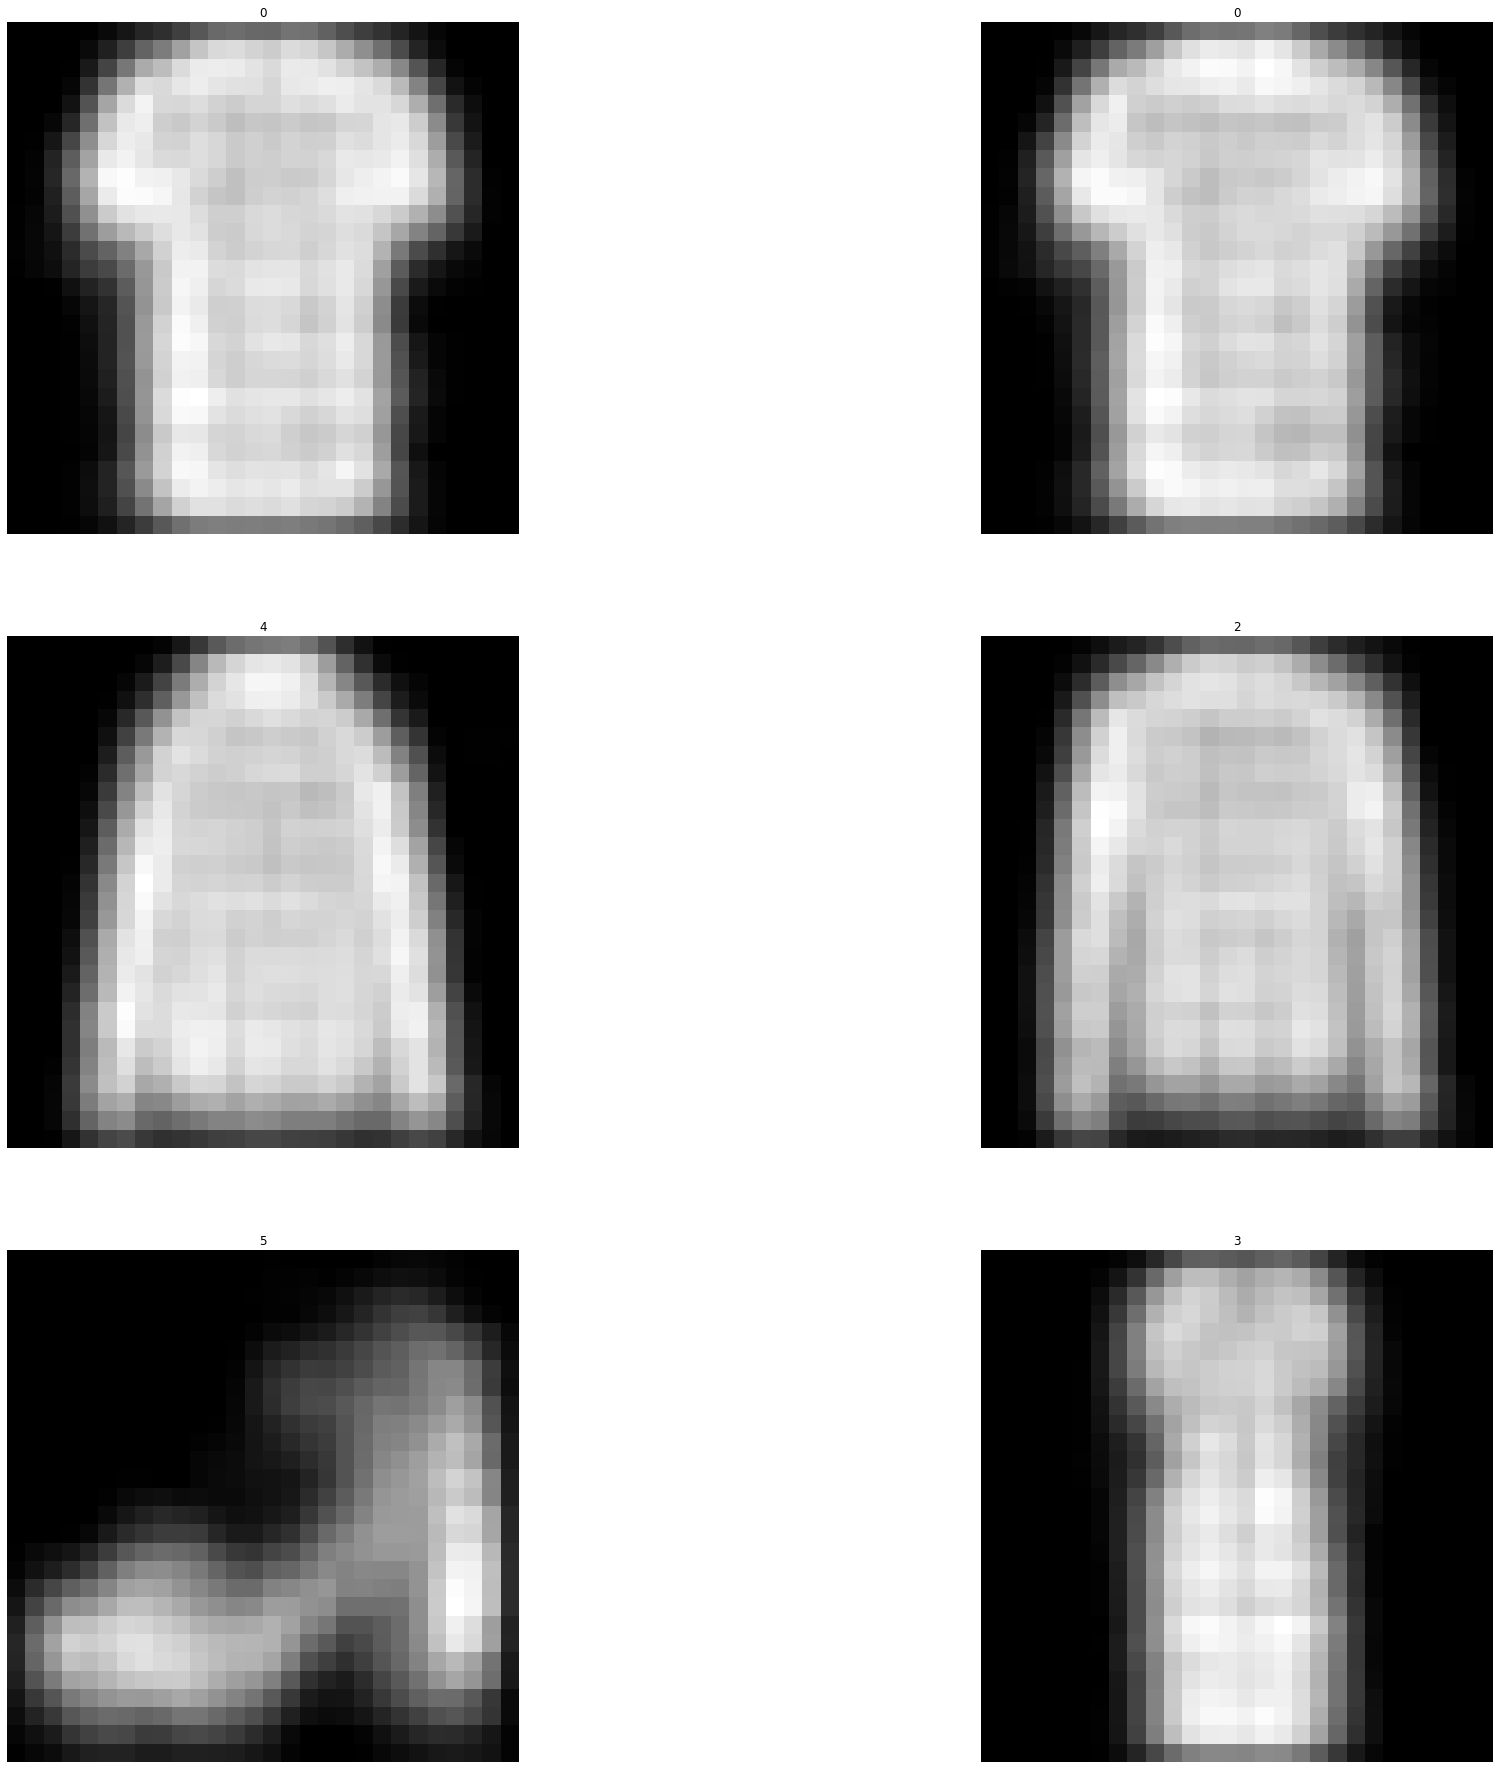

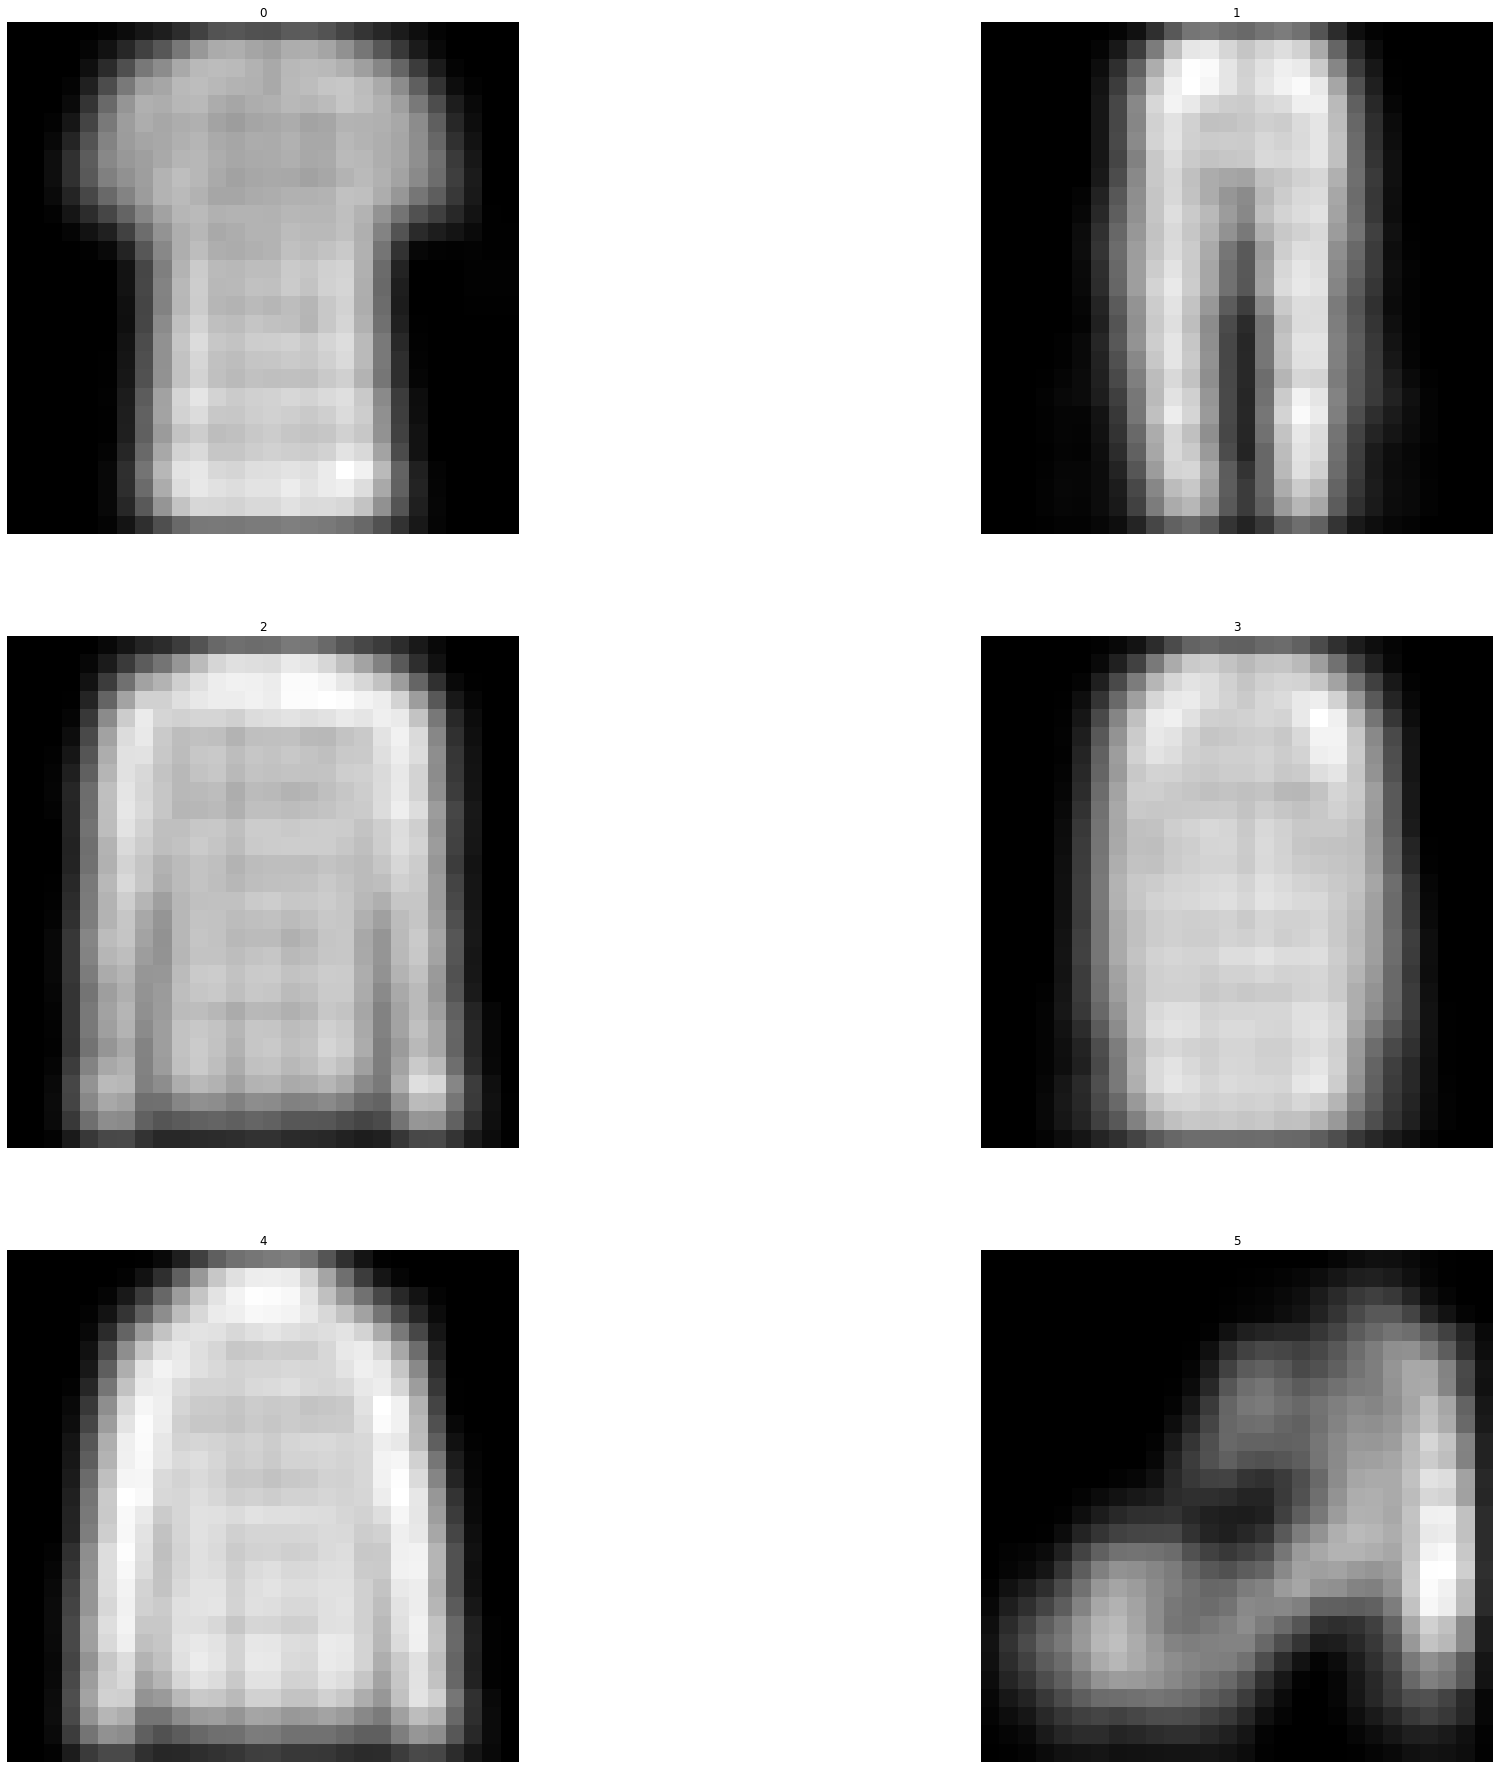

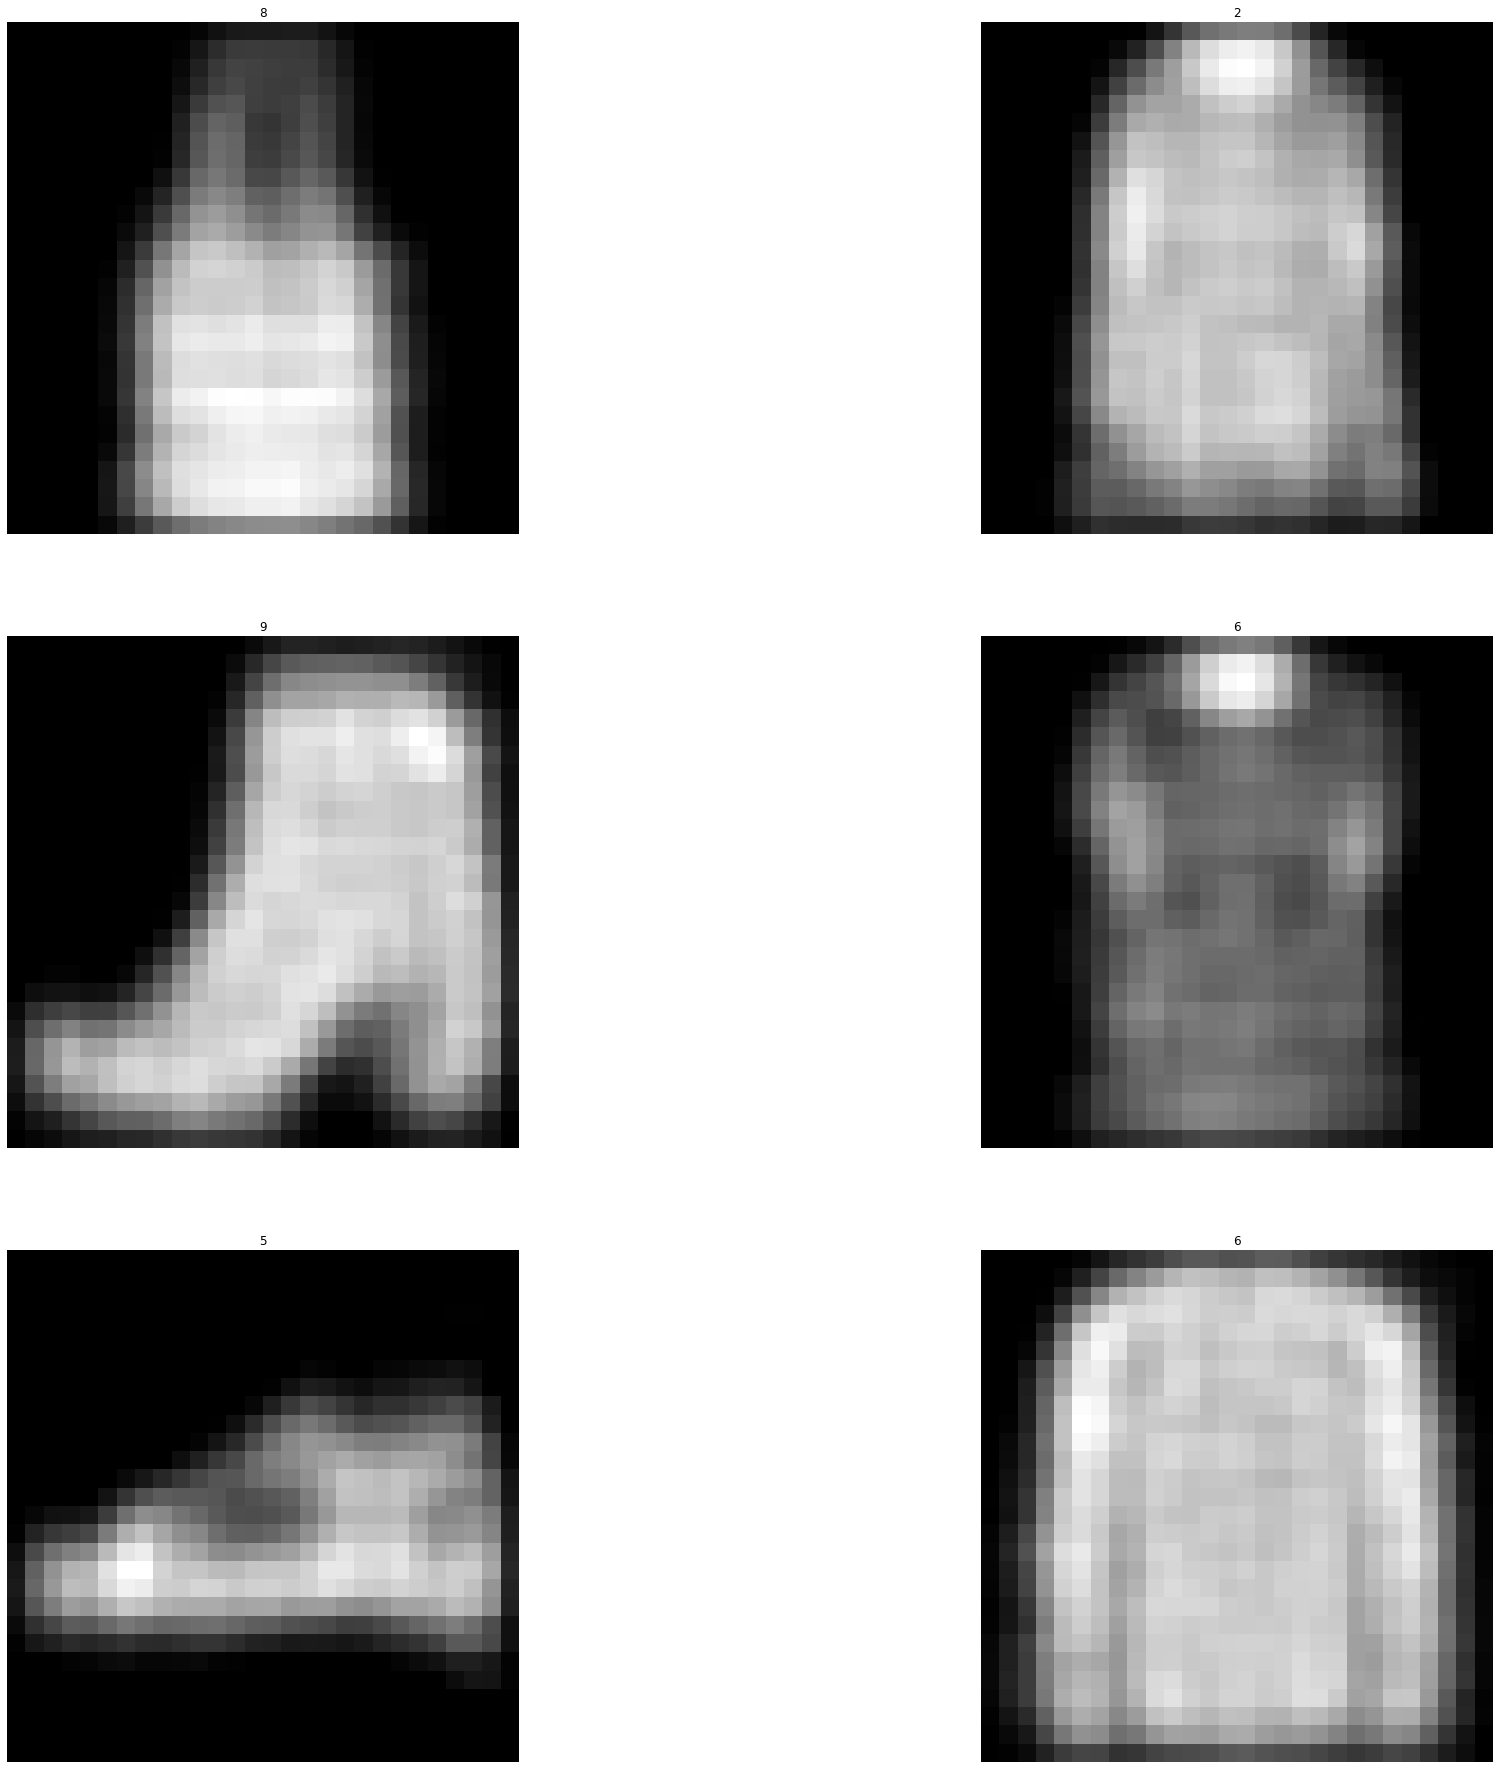

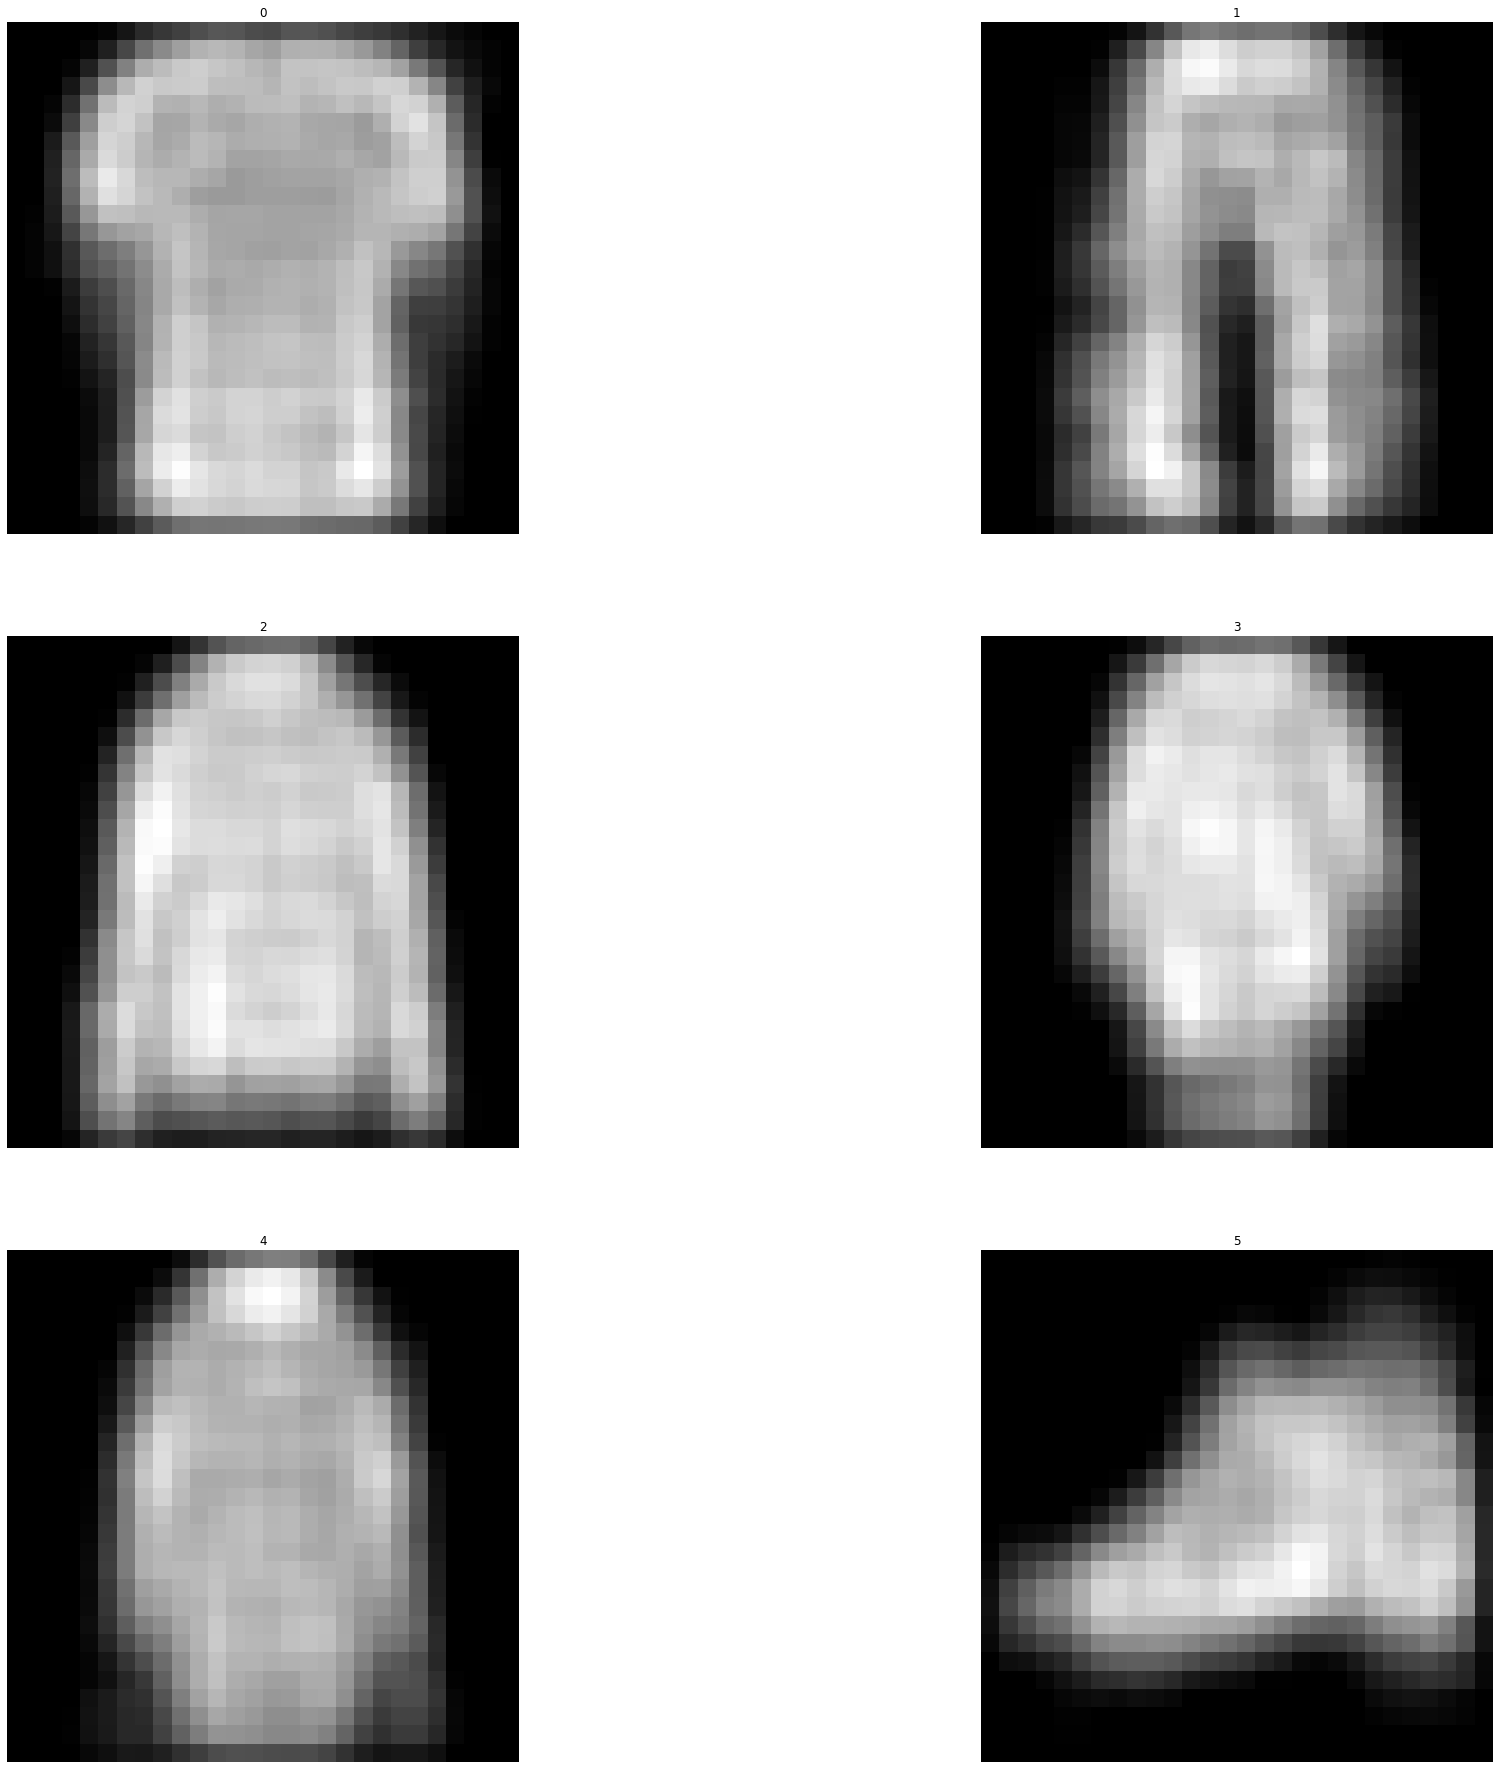

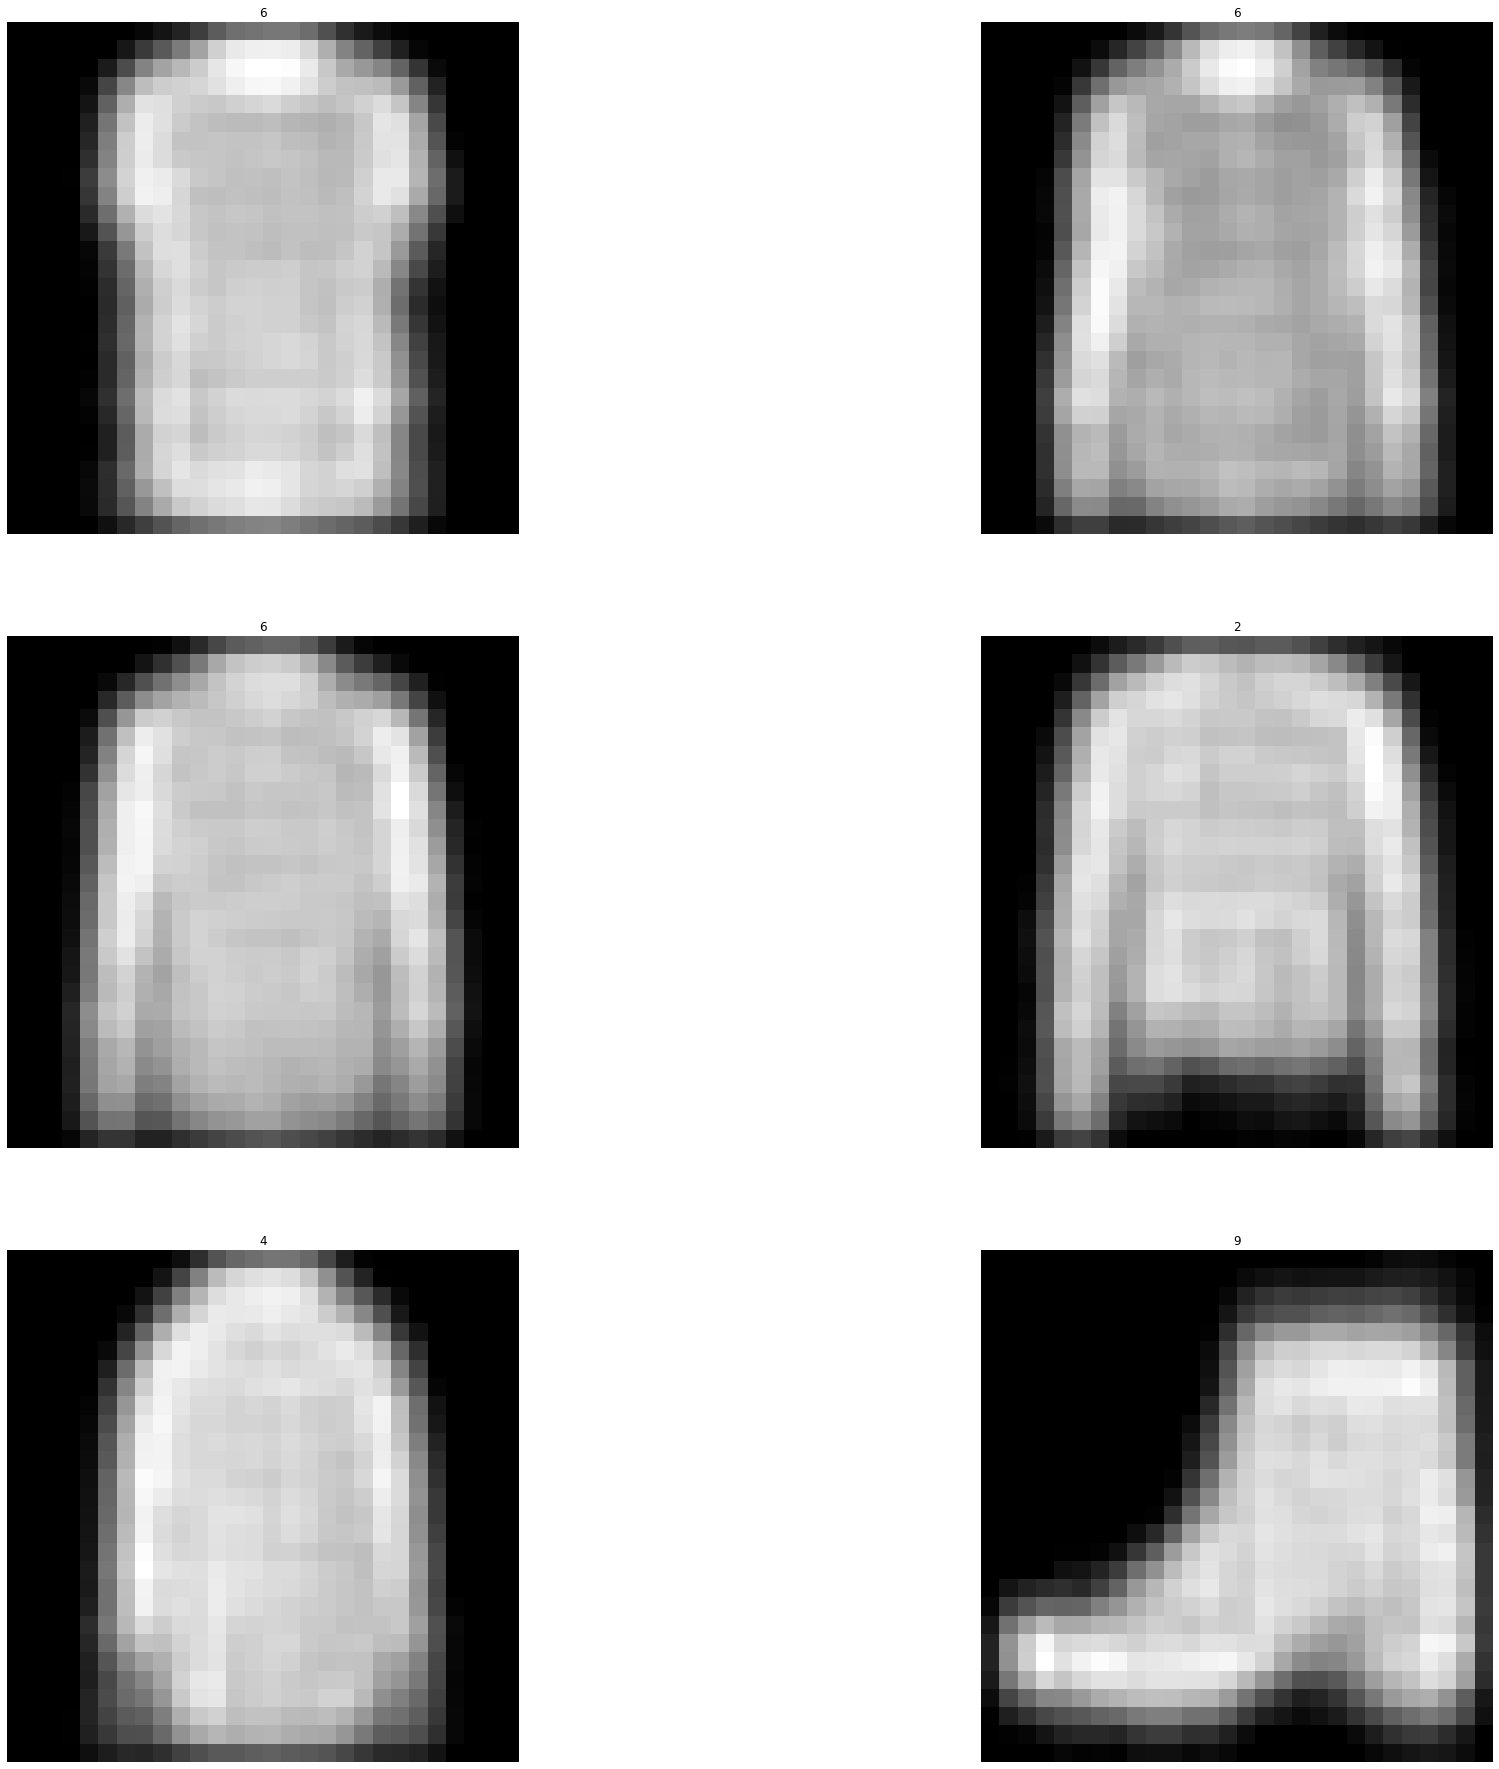

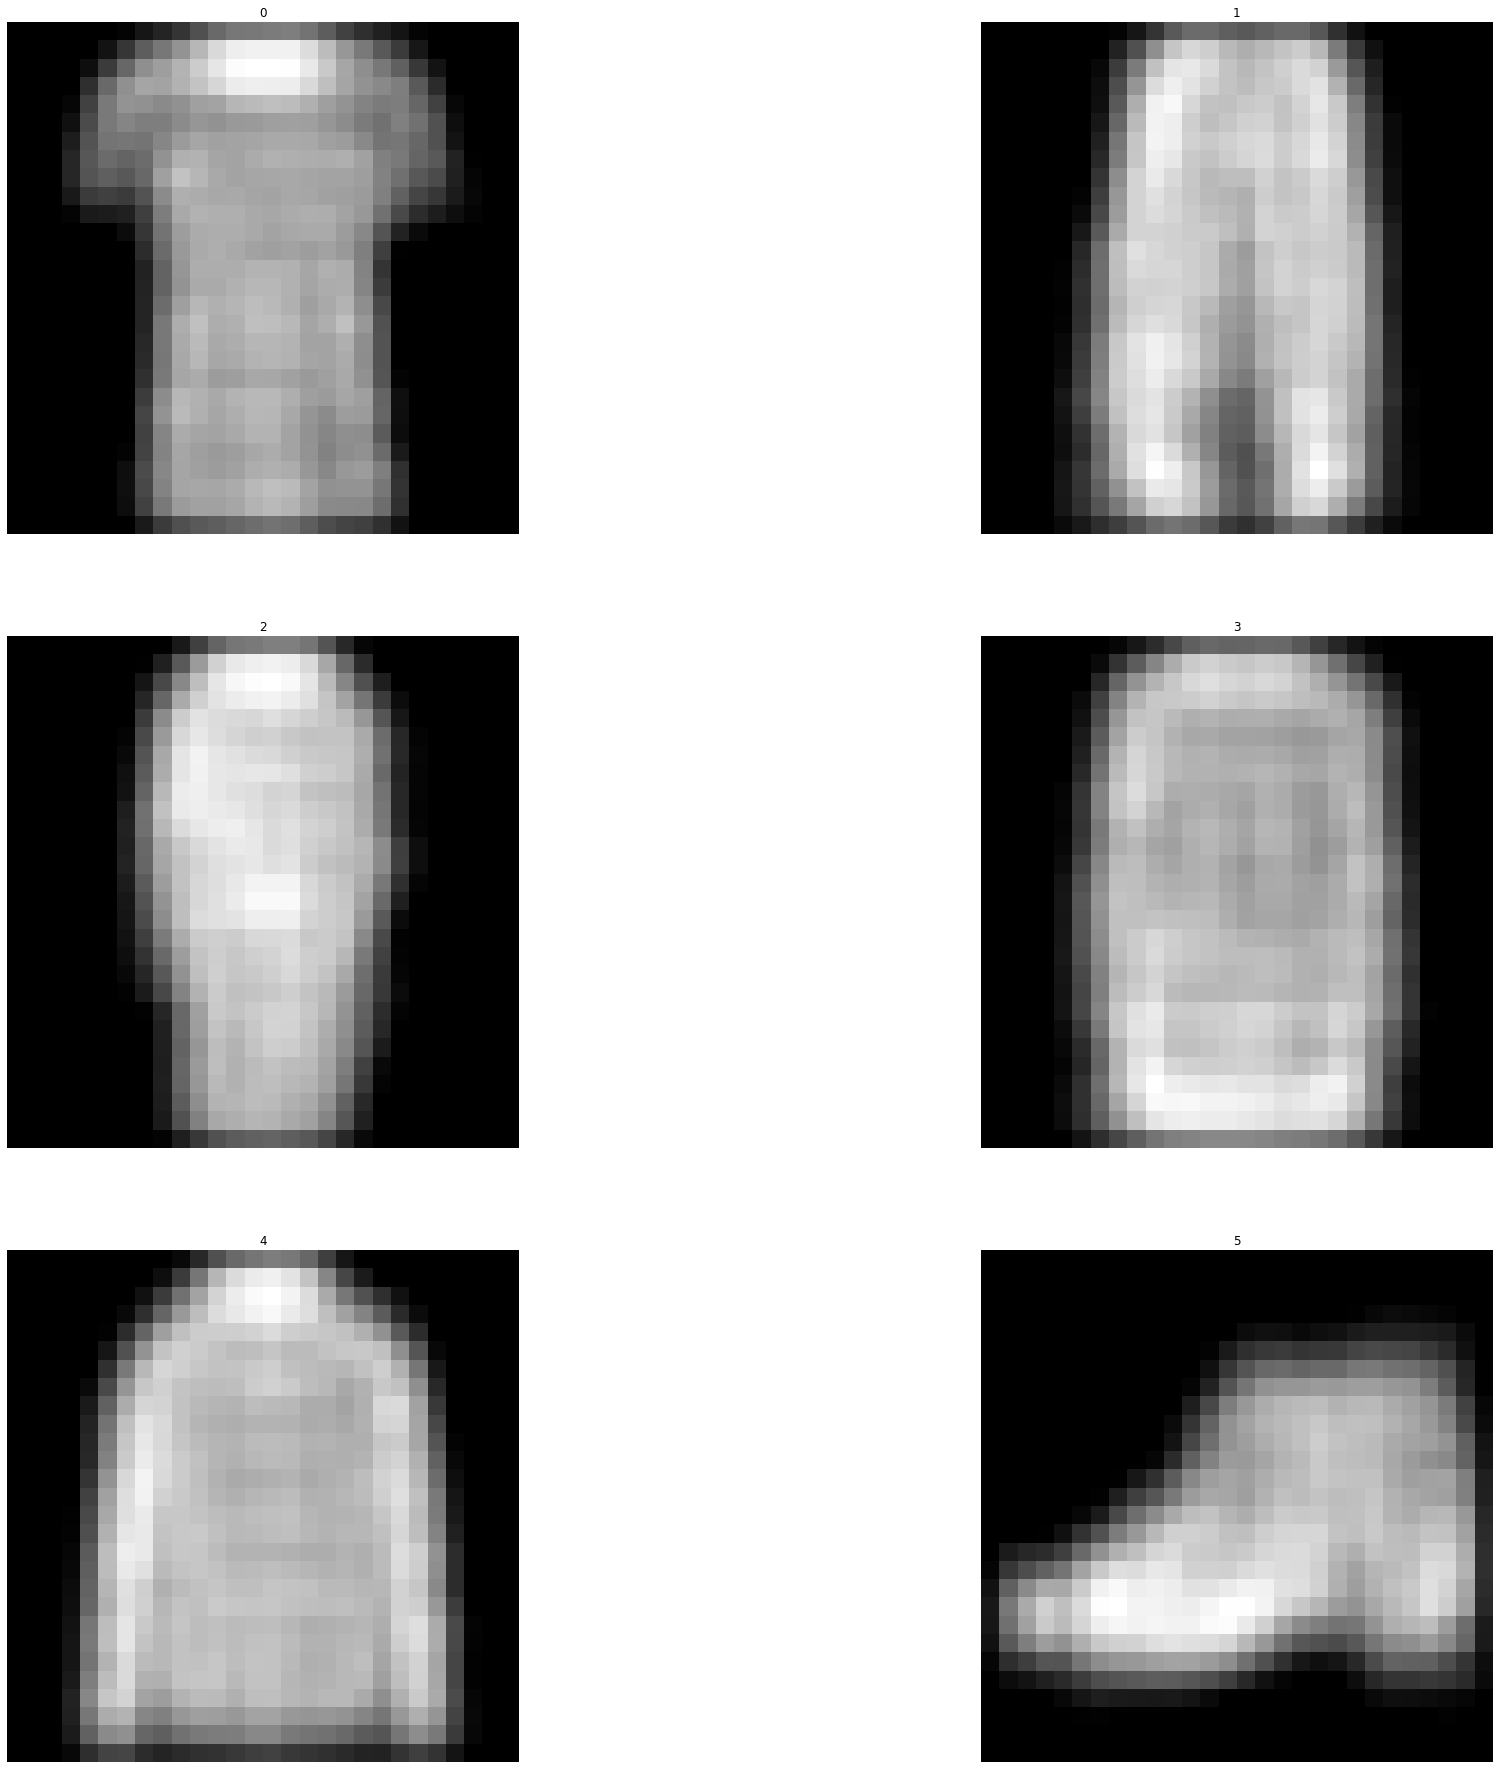

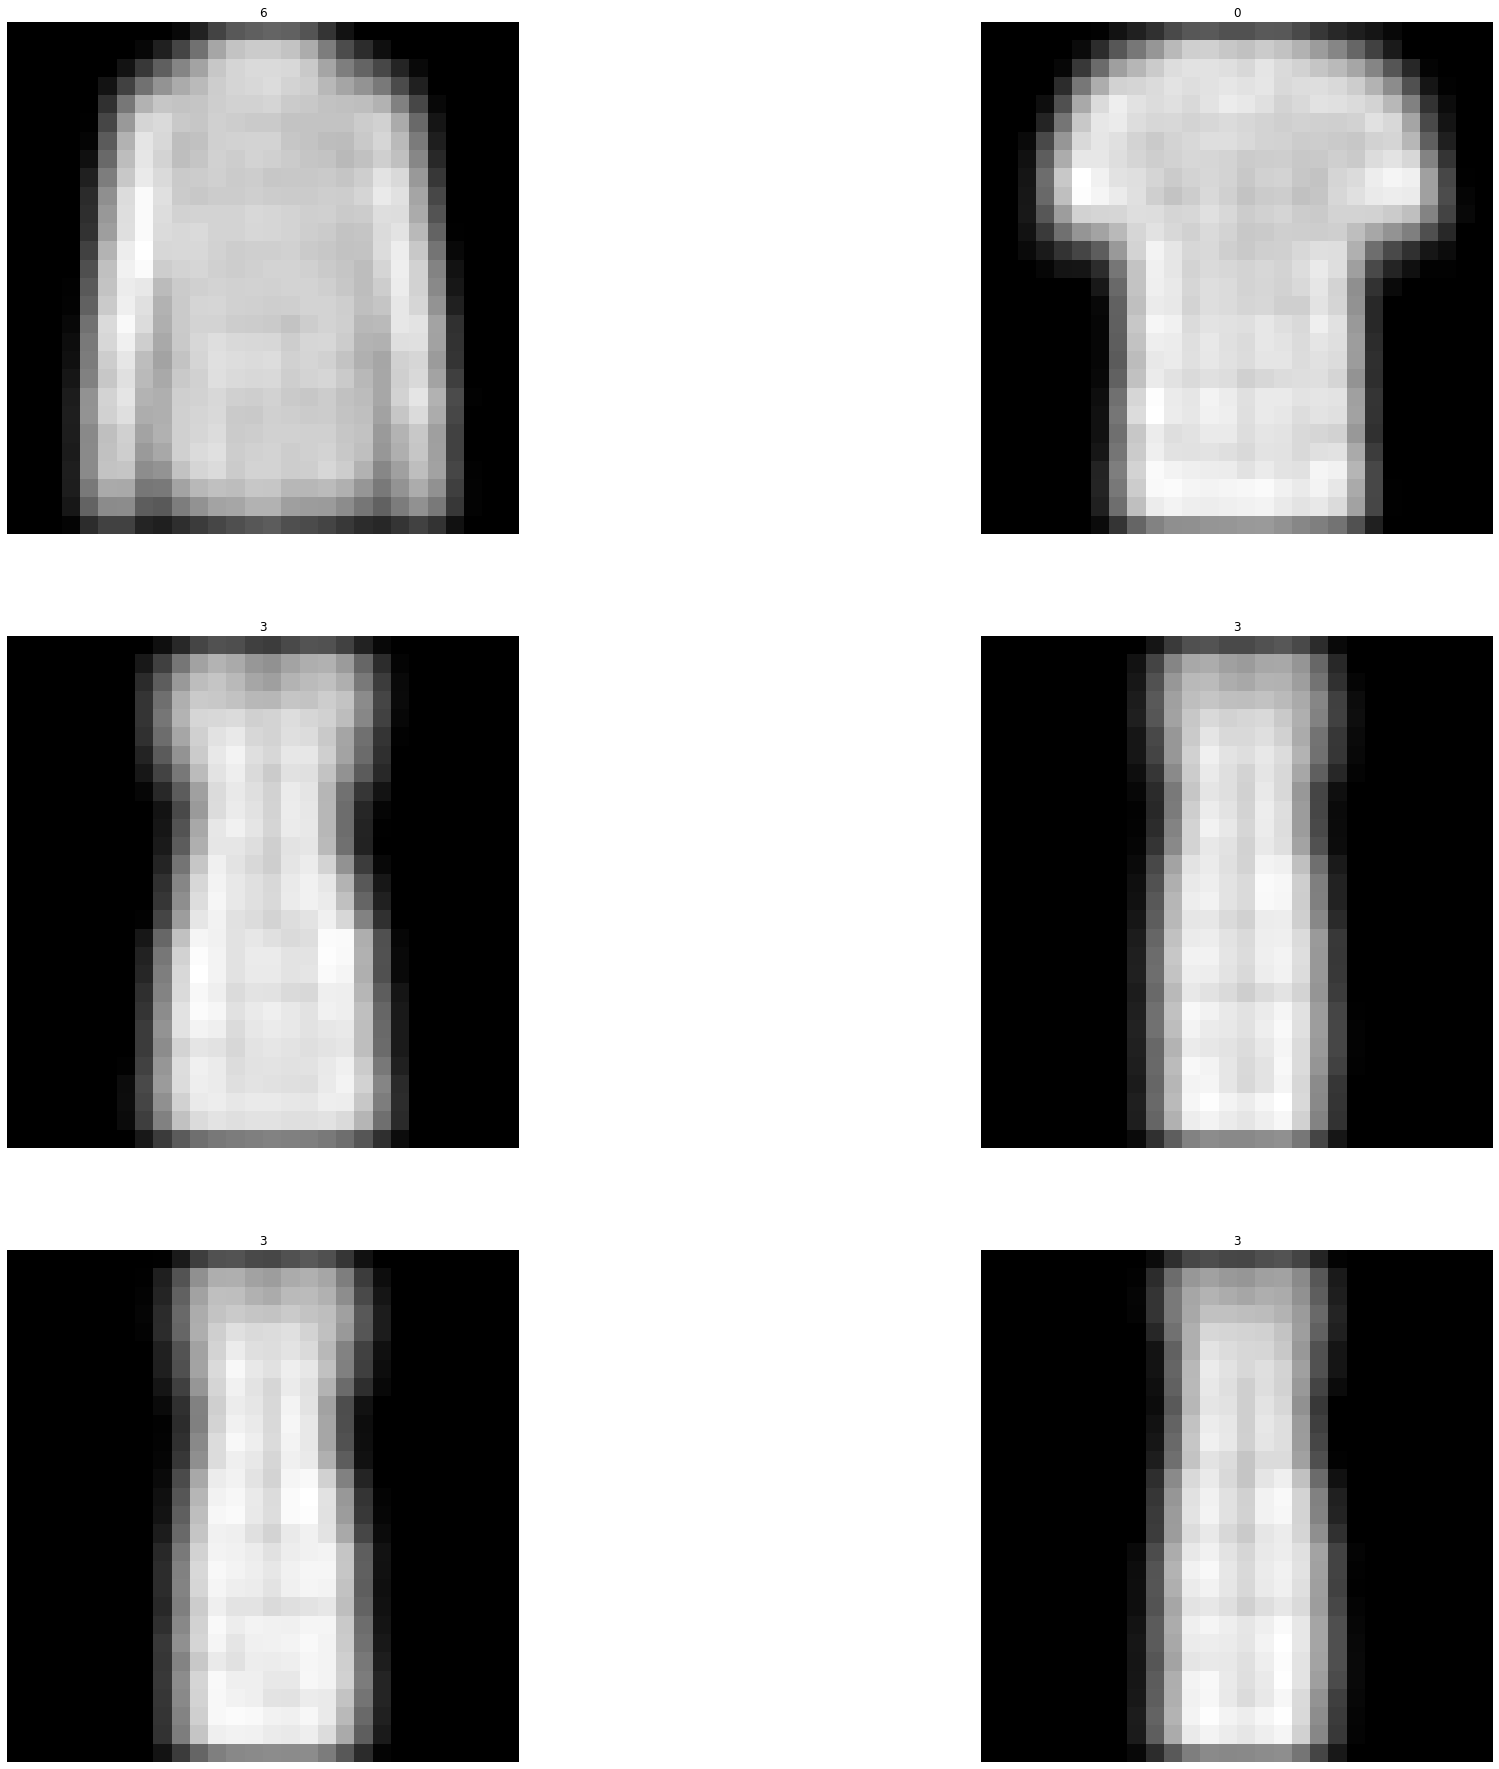

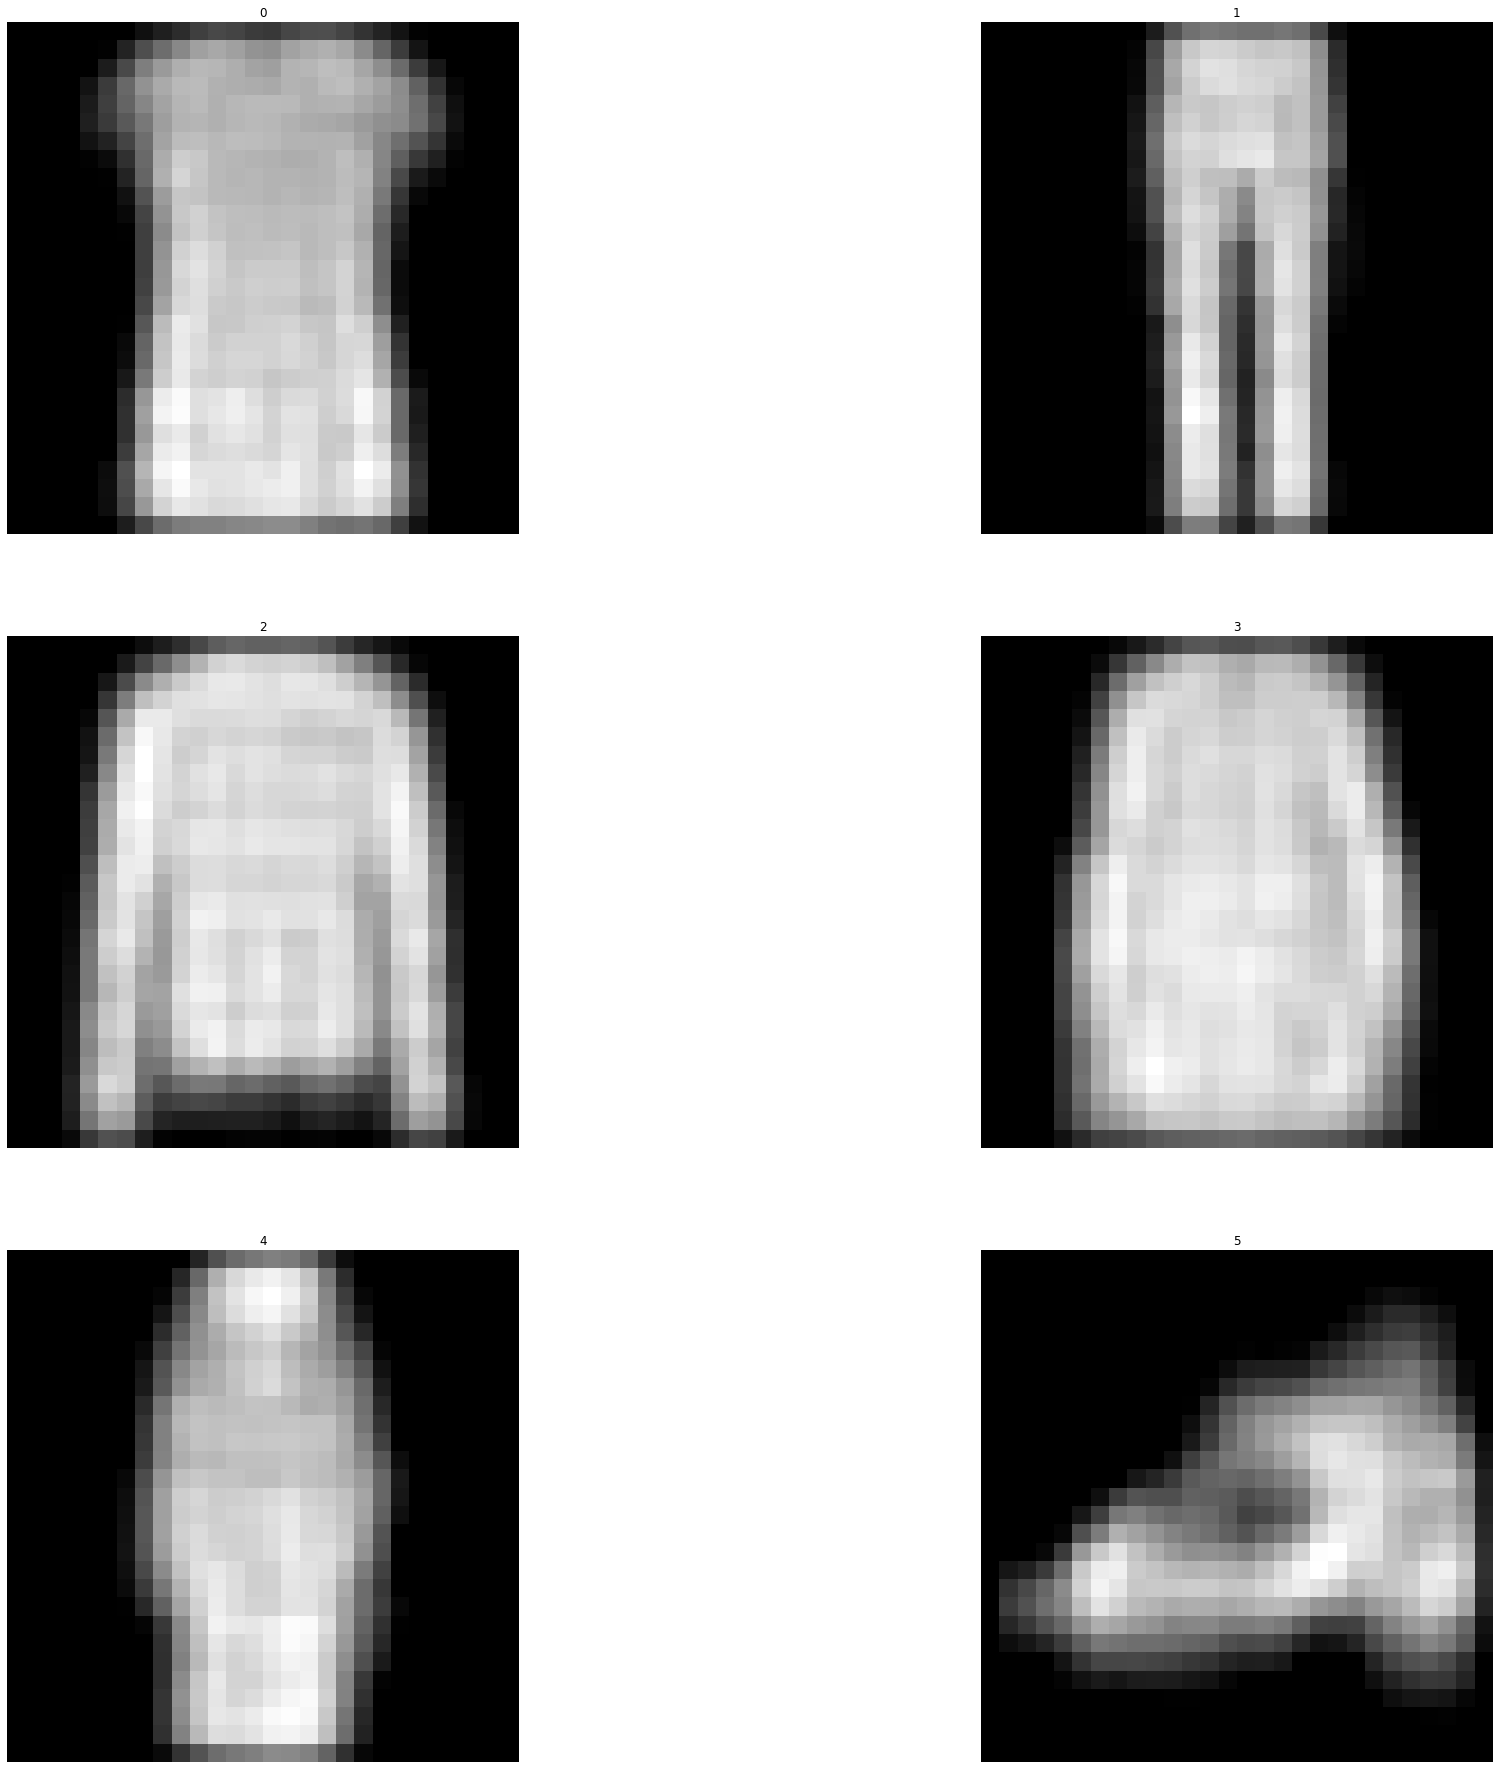

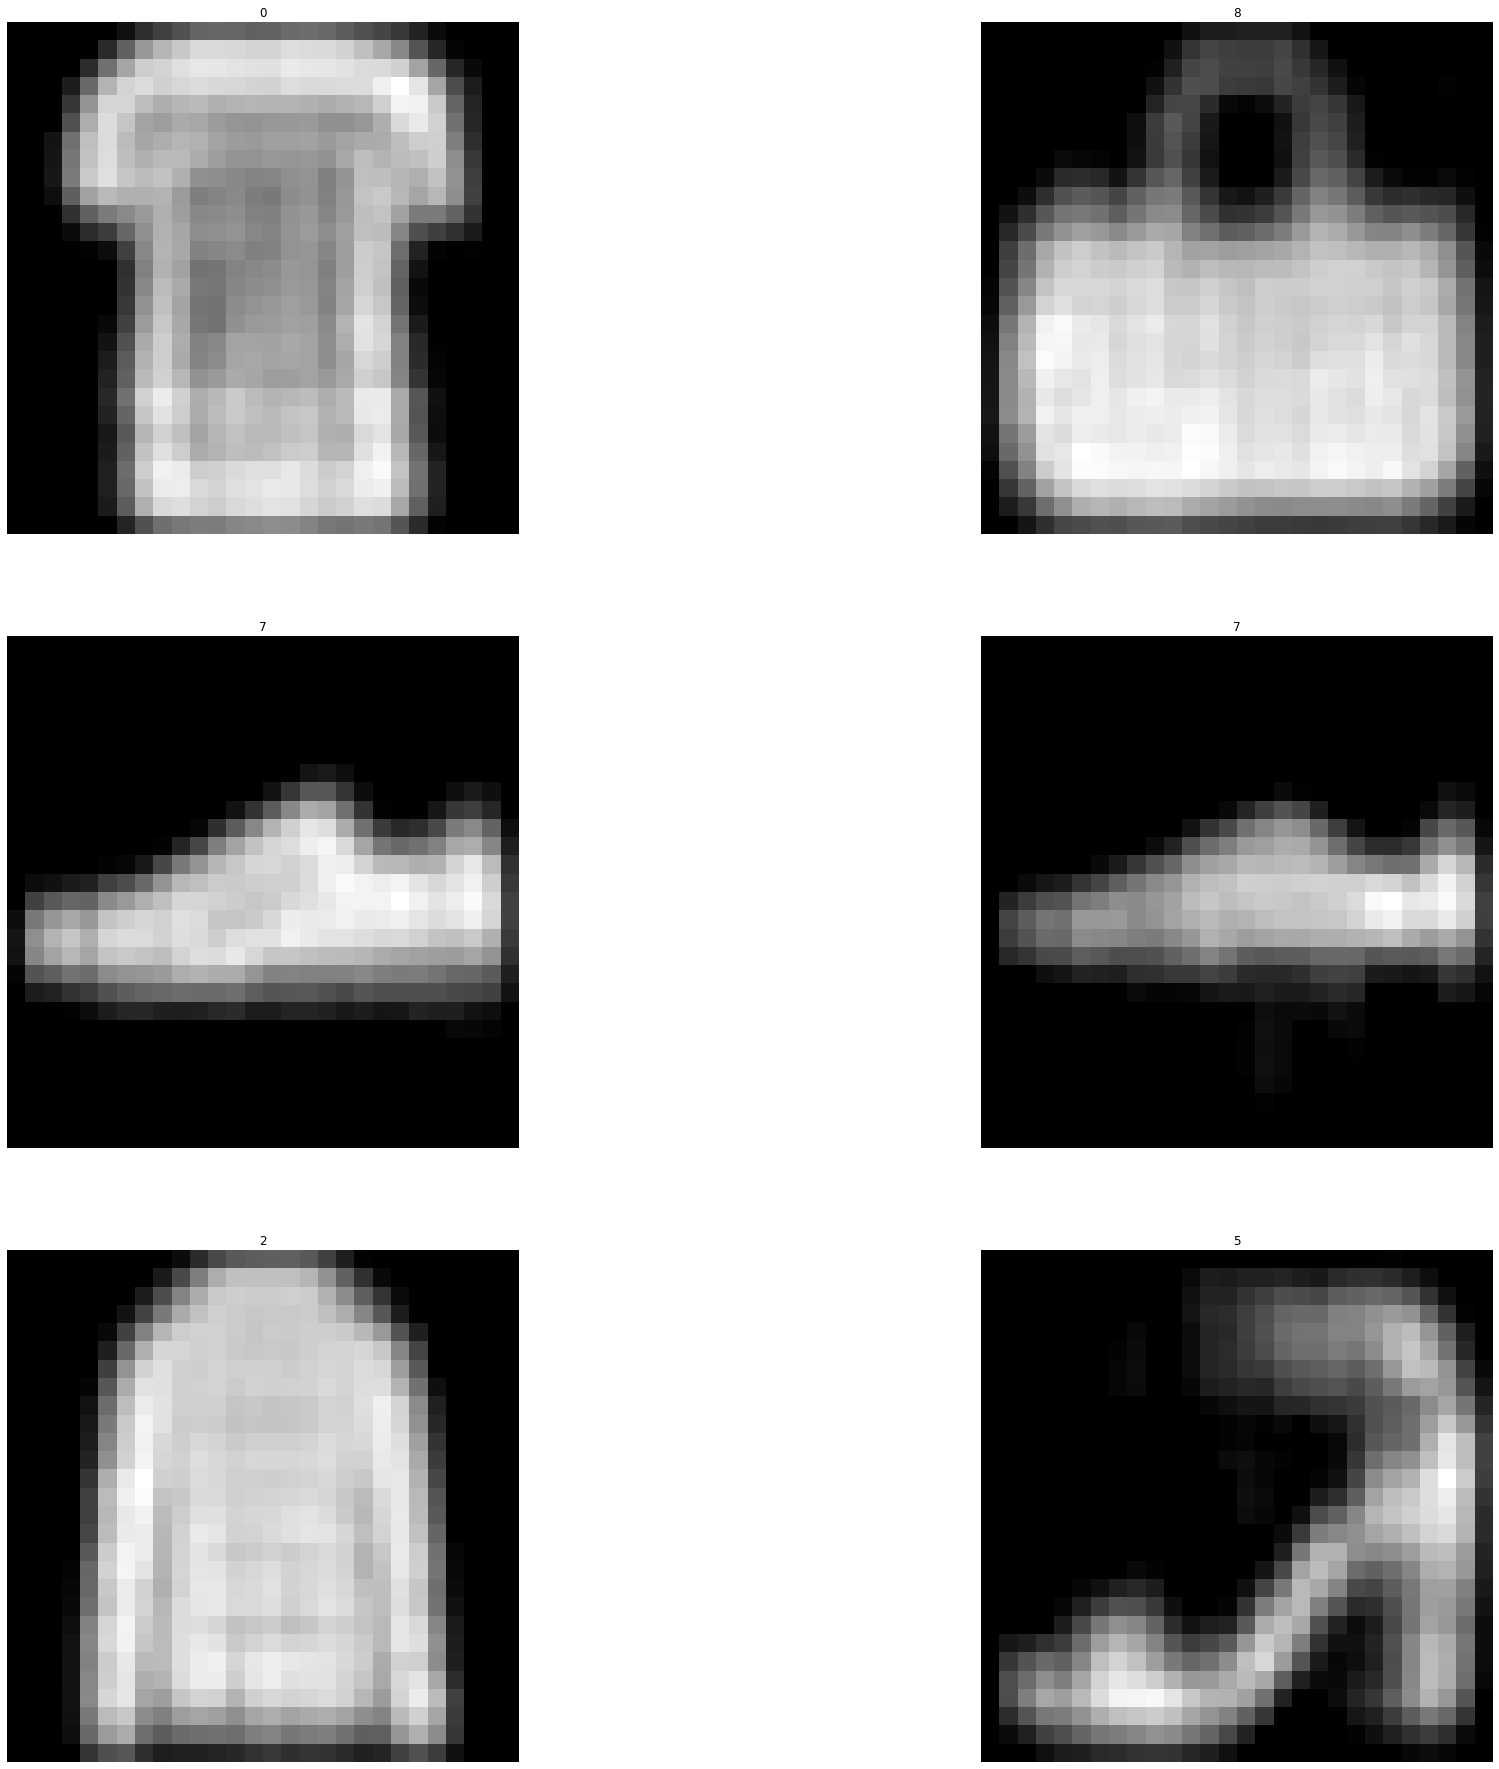

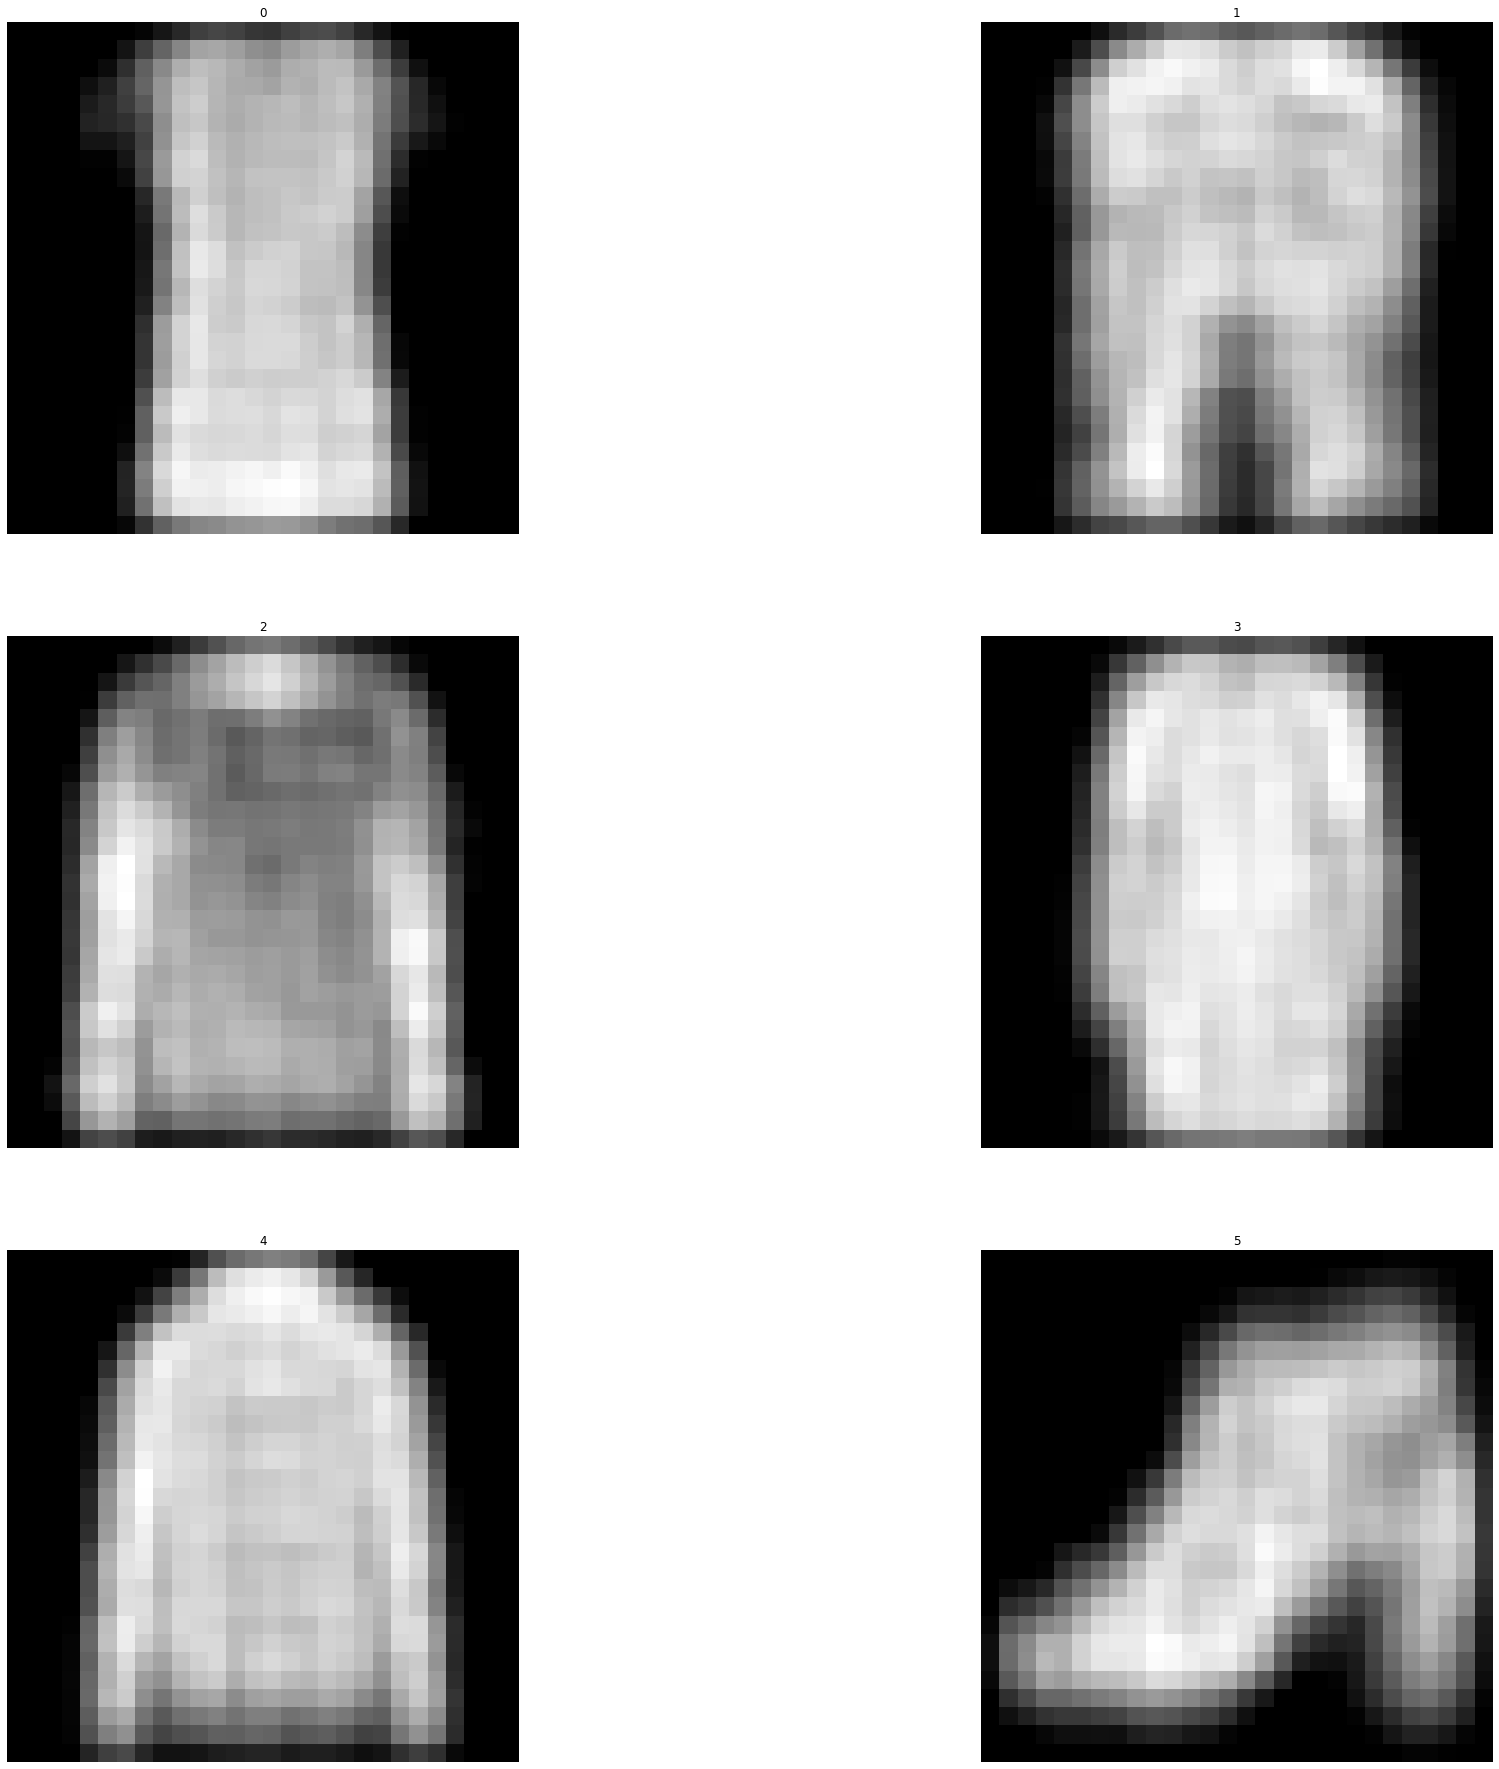

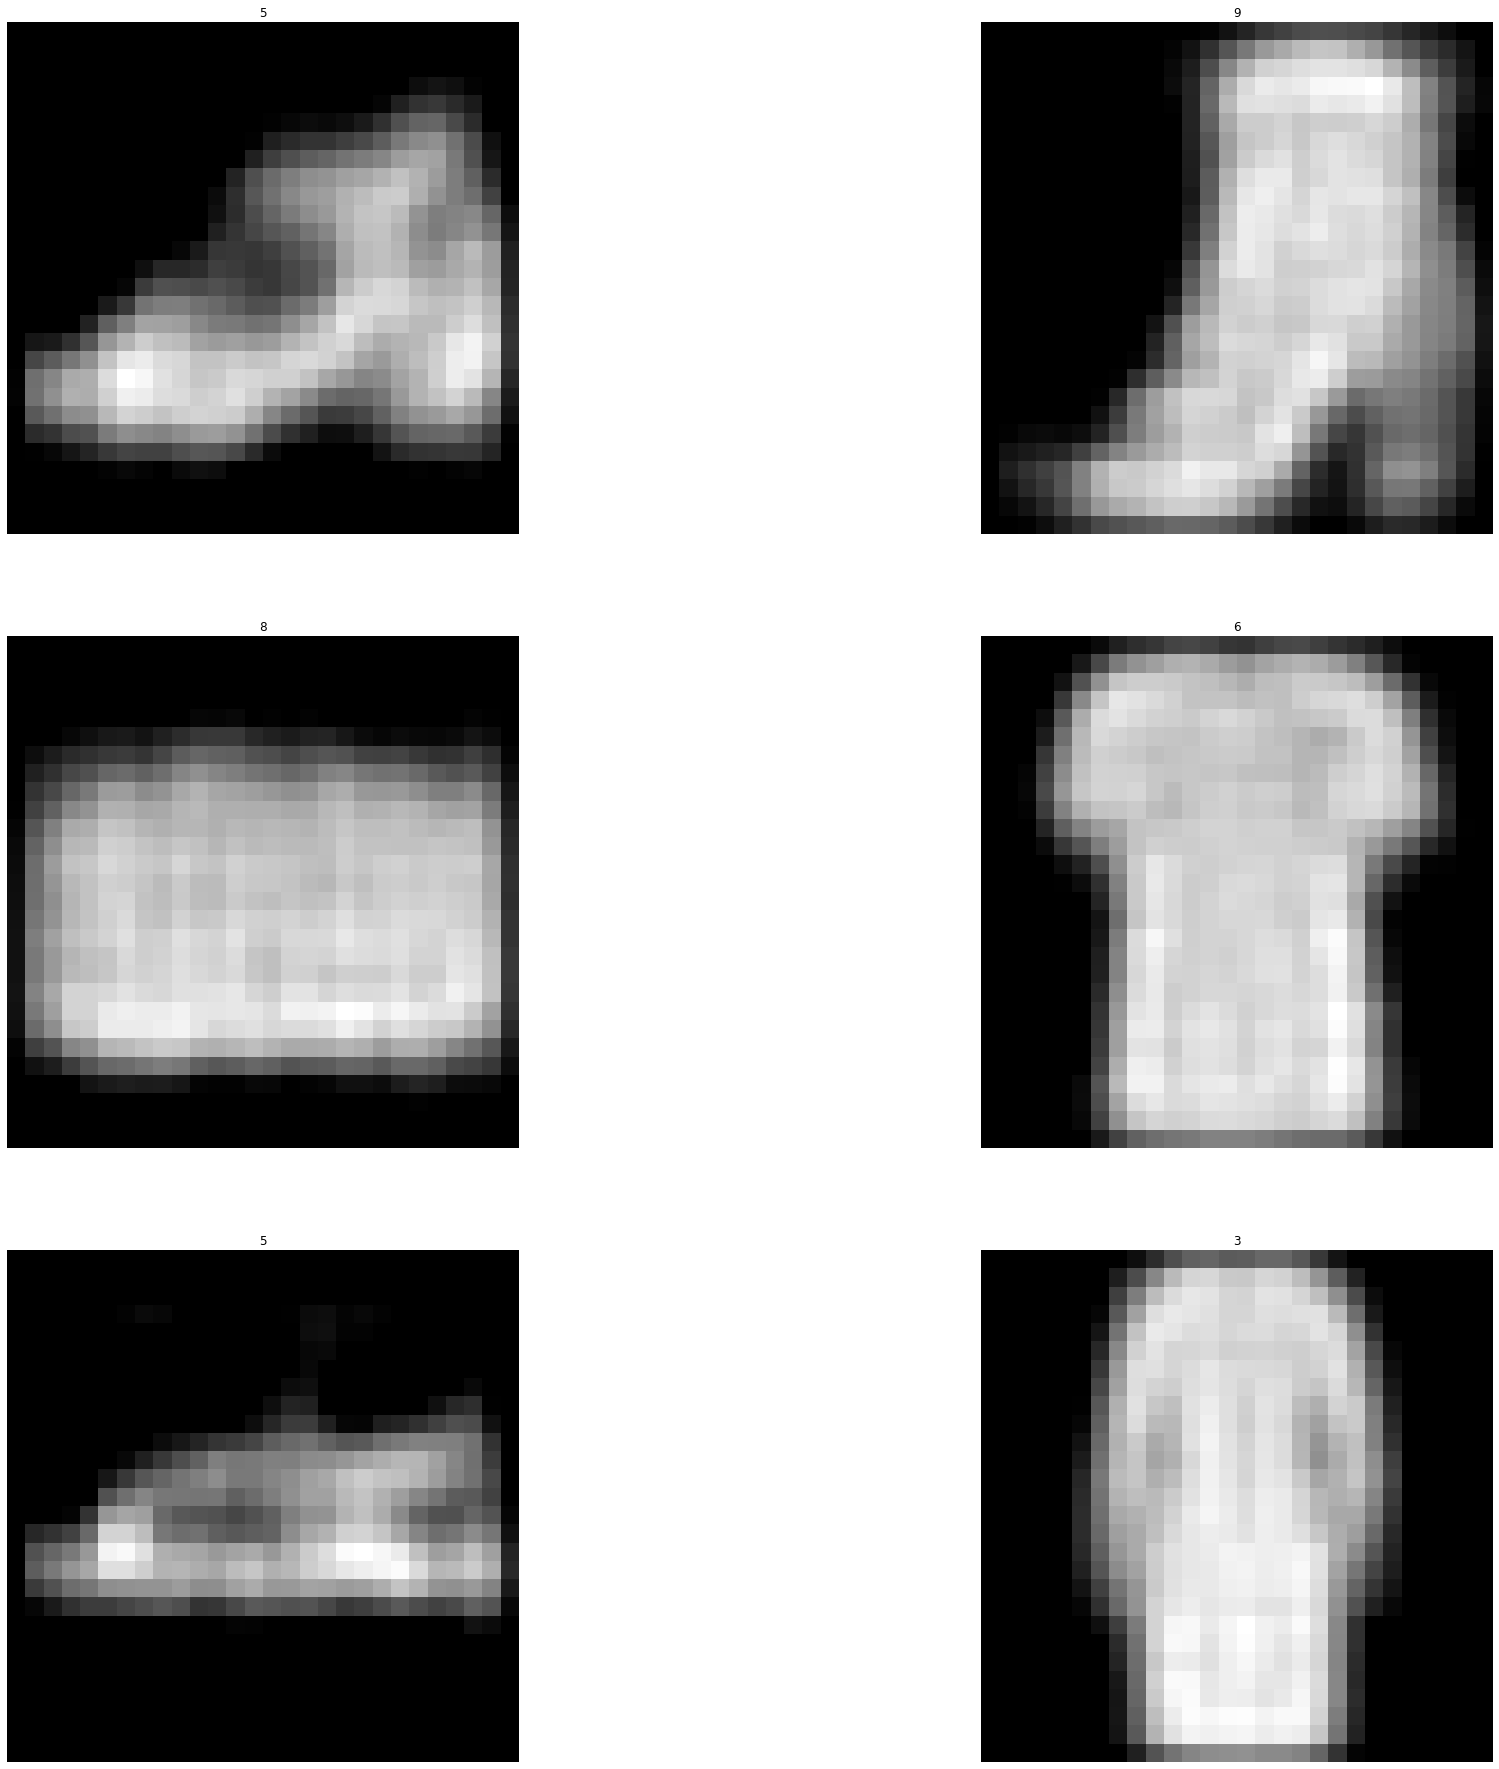

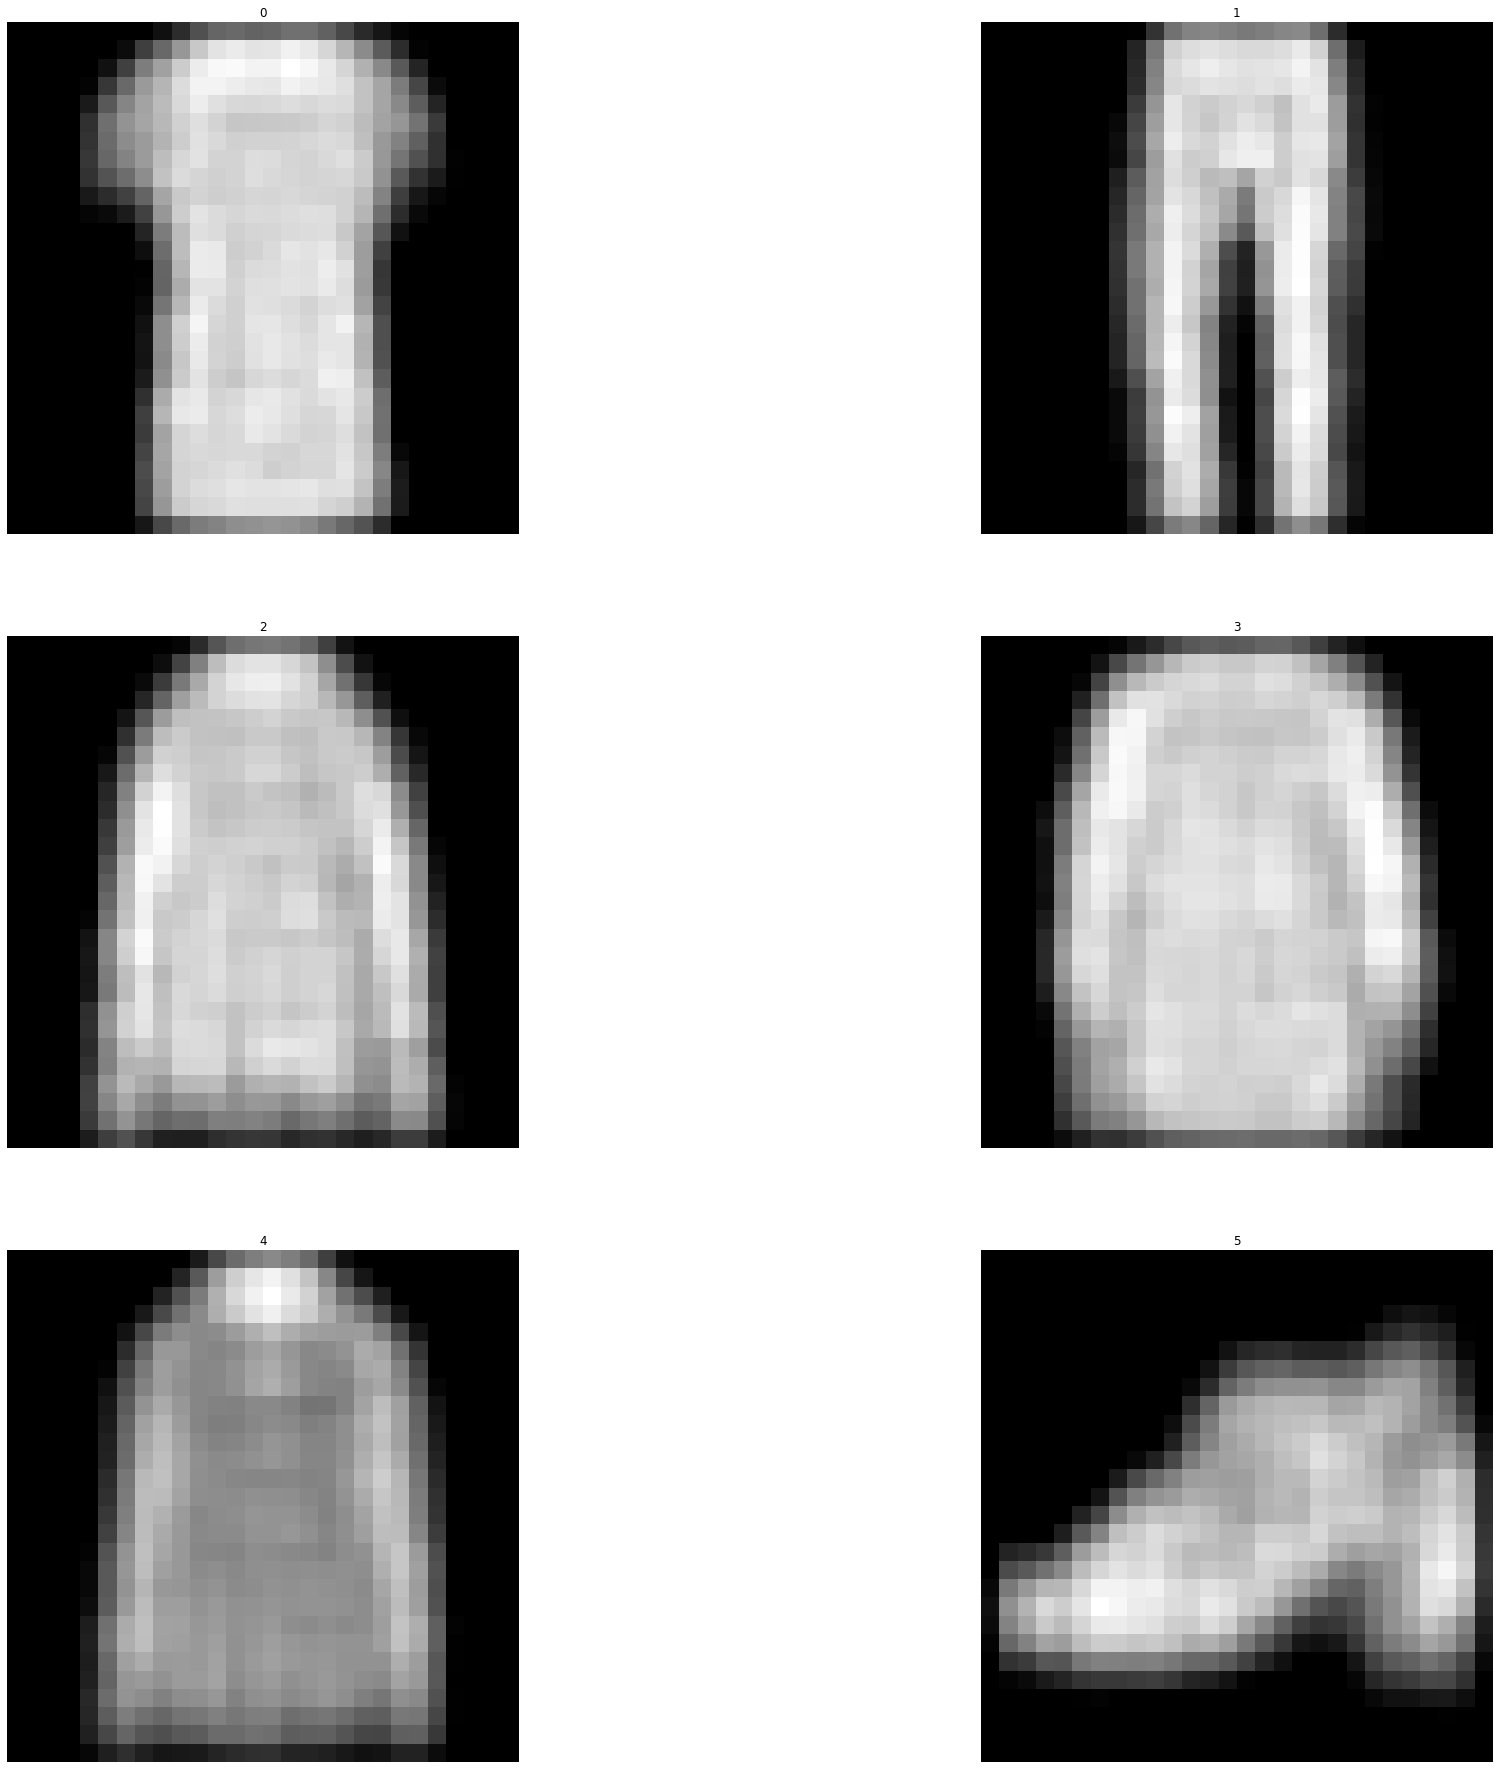

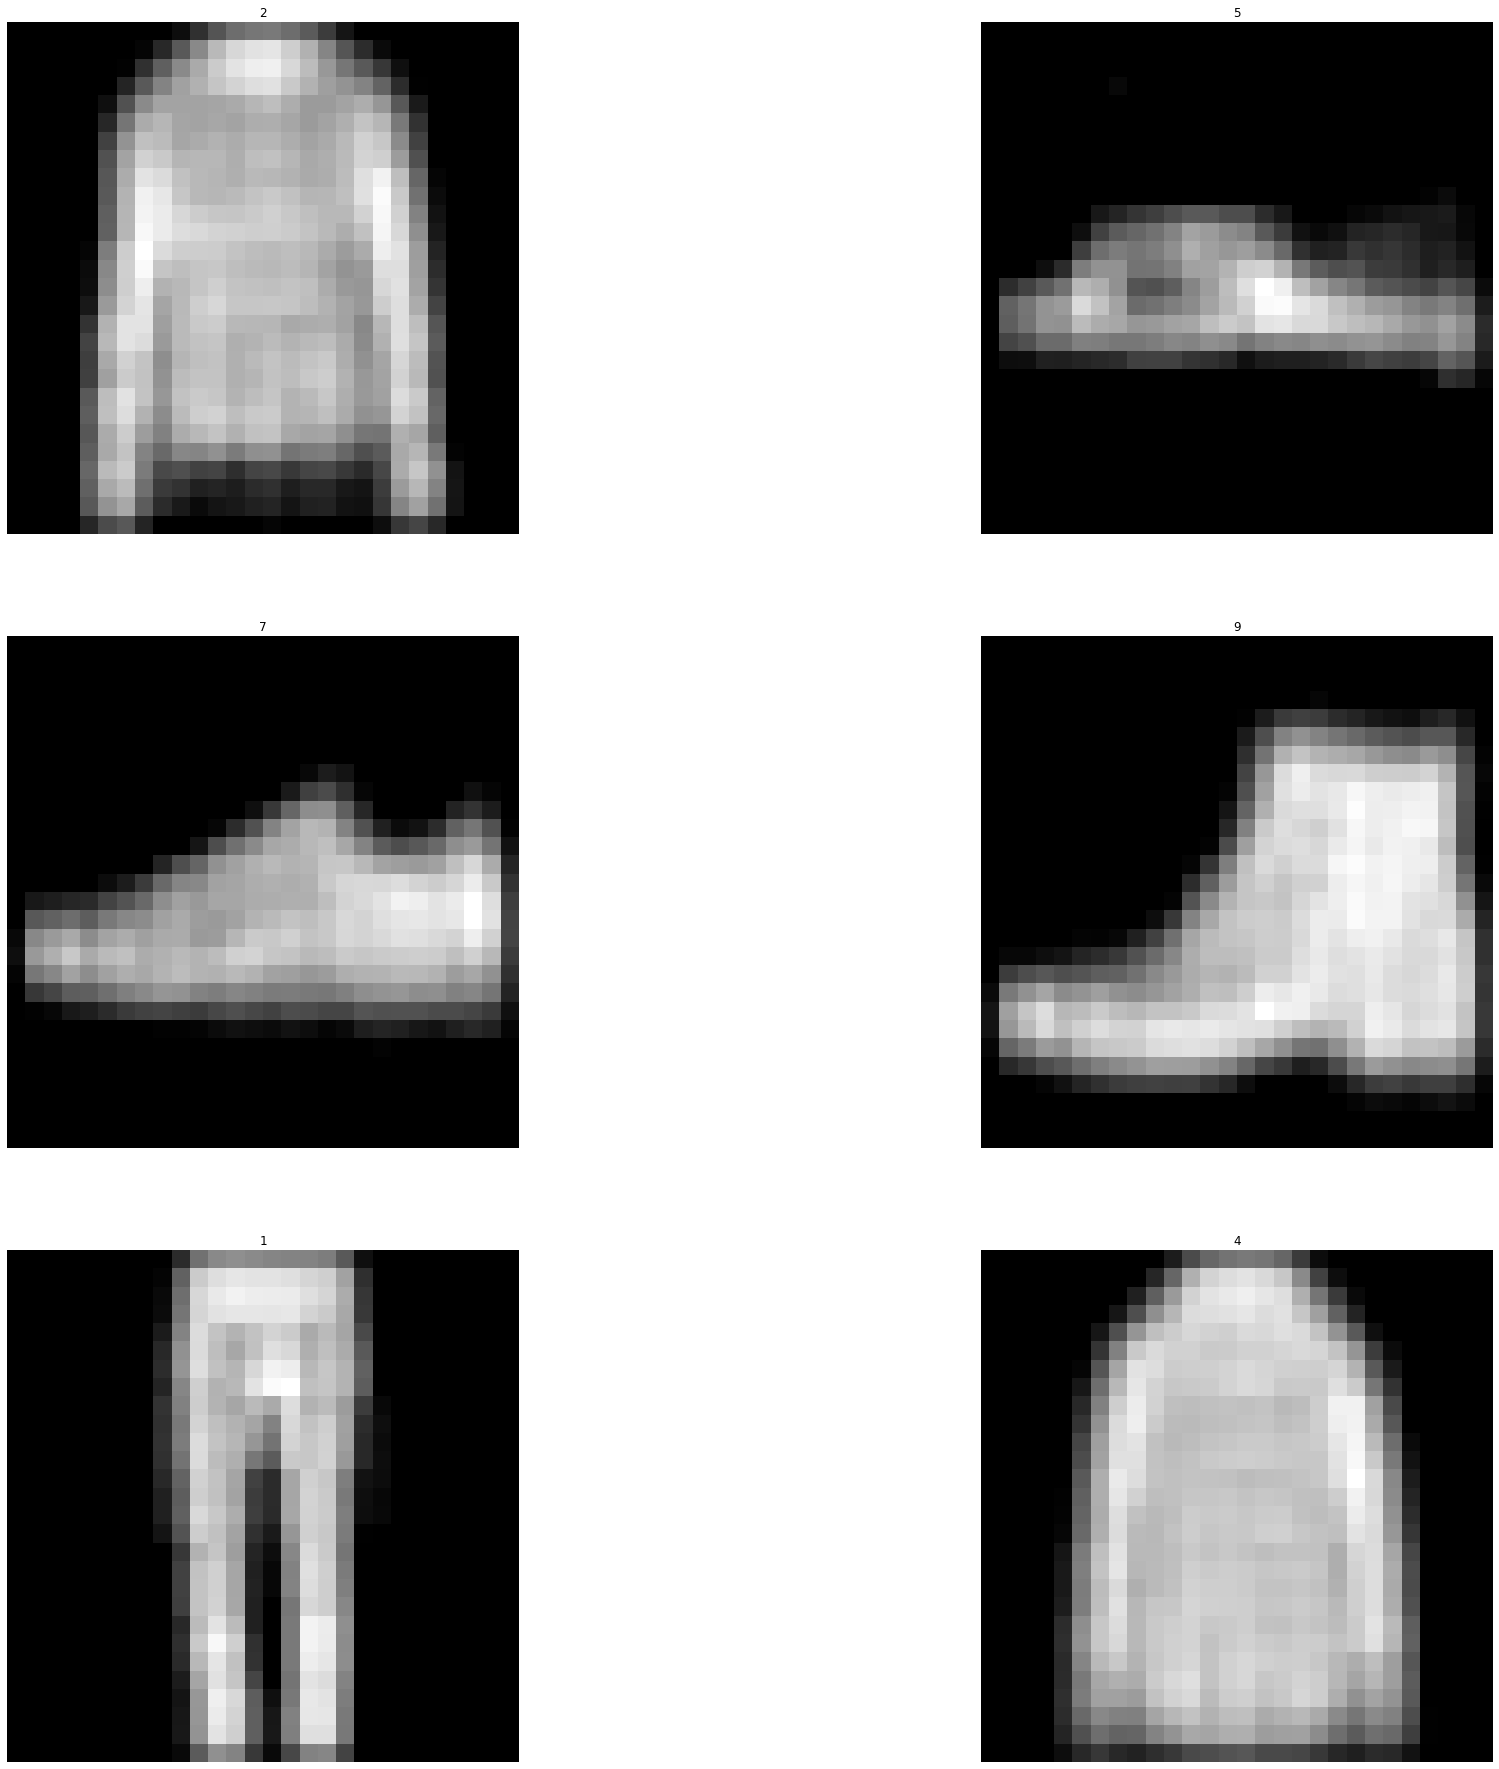

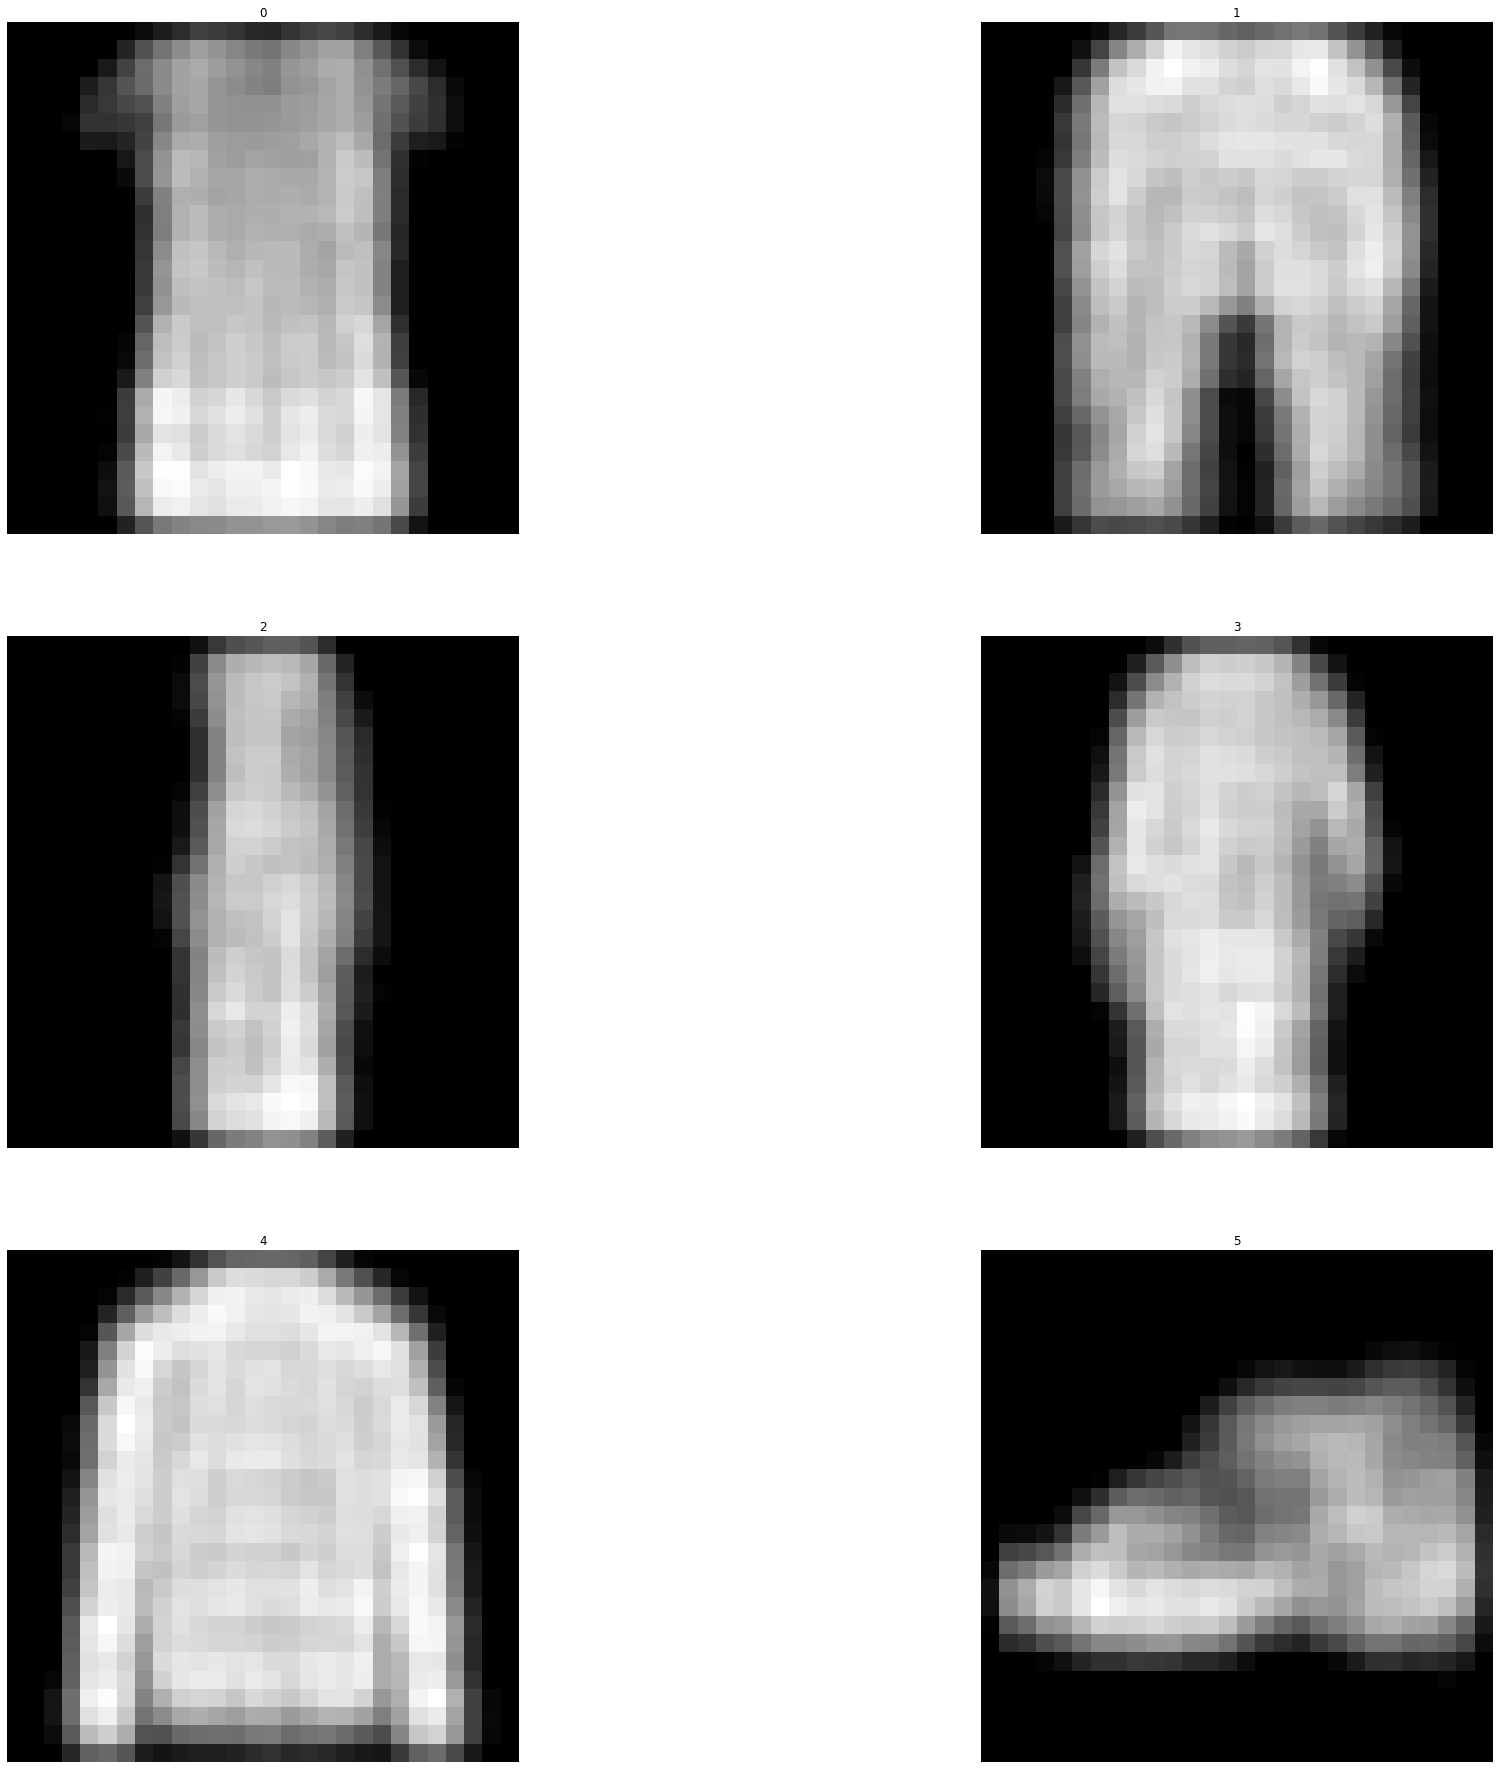

In [22]:
if __name__ == "__main__":
    train_loader, test_loader = load_data()
    print("dataloader created")
    model = CVAE().to(device)
    model.eval
    print("model created")
    
    if load_epoch > 0:
        model.load_state_dict(torch.load('./checkpoints/model_{}.pt'.format(load_epoch), map_location=torch.device('cpu')))
        #print("model {} loaded".format(load_epoch))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)


    train_loss_list = []
    test_loss_list = []
    for i in range(load_epoch+1, max_epoch):
        model.train()
        train_total, train_kld, train_loss = train(i, model, train_loader, optimizer)
        with torch.no_grad():
            model.eval()
            test_total, test_kld, test_loss = test(i, model, test_loader)
            if generate:
                z = torch.randn(6, 64).to(device)
                y = torch.tensor([1,2,3,4,5,6]) - 1
                generate_image(i,z, y, model)
            
        print("Epoch: {}/{} Train loss: {}, Train KLD: {}, Train Reconstruction Loss:{}".format(i, max_epoch,train_total, train_kld, train_loss))
        print("Epoch: {}/{} Test loss: {}, Test KLD: {}, Test Reconstruction Loss:{}".format(i, max_epoch, test_loss, test_kld, test_loss))
        

        save_model(model, i)
        train_loss_list.append([train_total, train_kld, train_loss])
        test_loss_list.append([test_total, test_kld, test_loss])
        np.save("train_loss", np.array(train_loss_list))
        np.save("test_loss", np.array(test_loss_list))